In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
# from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import networkx as nx
import random
import time
import pandas as pd
import math
import csv
import os

t0=time.time()
###########################################################
###########################################################

# Esta celda define funciones y carga librerías.
# También sirve para levantar el nombre de los archivos, por lo que cada vez que armes
# nuevos archivos tenés que volver a correrla para volver a registrar los nuevos nombres

############################################################
############################################################

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
# Vamos a leer los archivos con esta celda. Al darle la dirección de la carpeta Datos, lo que estoy sacando
# son los nombres de todos los archivos en esa carpeta.
#--------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

Tiempo()

Esto tardó 0.0 segundos


In [ ]:
t0=time.time()

# En esta celda voy a levantar los datos de opiniones y buscar encontrar el valor de error que
# me permita definir un criterio de corte para mi función principal
#-------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a construir la lista de Nombres de Opiniones


Nombres_Opiniones = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Evolucion":
        Nombres_Opiniones.append(nombre)



# Bien, las listas de nombres de archivos ya se arman correctamente

#-----------------------------------------------------------------------------
# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuáles son todos los N para los cuales existe un archivo.
# Por eso lo que voy a hacer es armar una lista, guardar TODOS los N ahí y después
# convertir la lista en conjunto para deshacerme de los duplicados

Conjunto_Agentes = []

for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
    Conjunto_Agentes.append(int(nombre.split("_")[3].split("=")[1]))

Conjunto_Agentes = set(Conjunto_Agentes)

# Bien, esto ya me arma el conjunto de agentes con todos los valores de N para los cuales
# hay un archivo de datos.

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de opiniones a ver que observo
for agentes in Conjunto_Agentes:
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente
        if agentes==N:
            #--------------------------------------------------------------------------------------------

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Opiniones[0],nombre))

            Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
            Ady = [int(x) for x in Ady]

            Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
            Sup = [float(x) for x in Sup]

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

            # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

            #--------------------------------------------------------------------------------------------

            # Hagamos un gráfico de estos datos
            # La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.
            # En otra celda empezaré a ver de hacer un gráfico que registre la trayectoria de la opinión de los agentes.

            X = np.arange(0,len(Opi))
            POC = {} # POC significa Promedio Opiniones Cuadradas.
            for j in range(T):
                # Obtengo los valores cuadrados de todos mis tópicos
                POC[j] = []
                for i in range(len(Opi)):
                    # TS es Tópicos Separados. Esta lista va a ir tomando todas las opiniones de un cierto tópico en una iteración
                    TS = [t**2 for t in Opi[i][j:len(Opi[i]):T]]
                    # Ahora los sumo y los agrego a mis vectores Y
                    POC[j].append(np.sum(TS)/len(TS))


            # El vector X con el número de iteraciones, así como el diccionario que guarda las opiniones de cada tópico por
            # separado funcionan correctamente. Ahora puedo cambiar el número de tópicos de mi sistema sin dramas.

            #-------------------------------------------------------------------------------------------

            # Hay que ver la forma de graficar esto correctamente, sin que estalle en términos de cantidad de
            # cosas graficadas, y que permita entenderse


            YT = np.zeros(len(Opi))
            for j in range(T):
                YT += np.array(POC[j])

            plt.plot(X,YT, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Promedio de Opiniones Cuadradas")
    plt.title("Evolución de las opiniones con N={} agentes".format(agentes))
    plt.legend()
    plt.grid()
    plt.savefig("../Imagenes/Corte/Opiniones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()


# El graficado de la función va bien, pero todavía siento que no puede bancarse cualquier cambio. Tengo que
# considerar un poco más los posibles casos.

Tiempo()

In [ ]:
t0 = time.time()

# En esta celda lo que voy a hacer es graficar los "errores" de mis sistemas. Es decir que voy a 
# estar mirando la suma del cuadrado de la diferencia del sistema en dos pasos temporales sucesivos. 
# La idea es ver cuánto cambia y a cuanto llega a medida que avanza en las iteraciones
# para poder establecer un criterio de corte de las iteraciones del sistema.

#--------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a armar la lista de Nombres de Errores.
        
Nombres_Errores = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Variacion":
        Nombres_Errores.append(nombre)

# Bien, las listas de nombres de archivos ya se arman correctamente

#-------------------------------------------------------------------------------------------
# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuáles son todos los N para los cuales existe un archivo.
# Por eso lo que voy a hacer es armar una lista, guardar TODOS los N ahí y después
# convertir la lista en conjunto para deshacerme de los duplicados

Conjunto_Agentes = []

for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
    Conjunto_Agentes.append(int(nombre.split("_")[3].split("=")[1]))
    
Conjunto_Agentes = set(Conjunto_Agentes)

# Bien, esto ya me arma el conjunto de agentes con todos los valores de N para los cuales
# hay un archivo de datos.

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de Variación de opinones a ver que observo
for agentes in Conjunto_Agentes:
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente

        #--------------------------------------------------------------------------------------------
        if agentes==N:

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Var = [float(x) for x in Datos[0][1:len(Datos[0])]]

            # Tengo correctamente levantados los datos de los errores

            #--------------------------------------------------------------------------------------------

            # Como lo único que tengo que graficar es el Error, ya tengo los datos armados. Sólo necesito
            # un vector X asociado.

            X = np.arange(0,len(Var))

            plt.semilogy(X,Var, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Variación promedio de las opiniones")
    plt.title("Variación Promedio del sistema para N={} agentes".format(agentes))
    plt.grid()
    plt.legend()
    plt.savefig("../Imagenes/Corte/Variaciones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()



Tiempo()

In [ ]:
t0 = time.time()

# En esta celda voy a graficar los datos obtenidos con el mecanismo de corte implementado.
# Voy a graficar las opiniones y las variaciones promedio, todo en esta celda.
# Las imágenes las voy a guardar en la carpeta "Interacción Pares" dentro de imágenes

#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Interaccion Pares")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a construir la lista de Nombres de Opiniones


Nombres_Opiniones = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Evolucion":
        Nombres_Opiniones.append(nombre)



# Bien, las listas de nombres de archivos ya se arman correctamente

#-----------------------------------------------------------------------------

# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuál es el máximo y mínimo número de agentes. Por razones.

Nmin = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])
Nmax = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])

# Defino un Nmin y Nmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
    N = int(nombre.split("_")[3].split("=")[1])
    Nmin = min(N,Nmin)
    Nmax = max(N,Nmax)

# Bien, esto ya me obtiene los valores de Nmin y Nmax correctamente

#-------------------------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Variacion_Promedio_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a armar la lista de Nombres de Errores.
        
Nombres_Errores = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Variacion":
        Nombres_Errores.append(nombre)

# Bien, las listas de nombres de archivos ya se arman correctamente

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de opiniones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente
        if agentes==N:
            #--------------------------------------------------------------------------------------------

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Opiniones[0],nombre))

            Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
            Ady = [int(x) for x in Ady]

            Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
            Sup = [float(x) for x in Sup]

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

            # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

            #--------------------------------------------------------------------------------------------

            # Hagamos un gráfico de estos datos
            # La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.
            # En otra celda empezaré a ver de hacer un gráfico que registre la trayectoria de la opinión de los agentes.

            X = np.arange(0,len(Opi))
            POC = {} # POC significa Promedio Opiniones Cuadradas.
            for j in range(T):
                # Obtengo los valores cuadrados de todos mis tópicos
                POC[j] = []
                for i in range(len(Opi)):
                    # TS es Tópicos Separados. Esta lista va a ir tomando todas las opiniones de un cierto tópico en una iteración
                    TS = [t**2 for t in Opi[i][j:len(Opi[i]):T]]
                    # Ahora los sumo y los agrego a mis vectores Y
                    POC[j].append(np.sum(TS)/len(TS))


            # El vector X con el número de iteraciones, así como el diccionario que guarda las opiniones de cada tópico por
            # separado funcionan correctamente. Ahora puedo cambiar el número de tópicos de mi sistema sin dramas.

            #-------------------------------------------------------------------------------------------

            # Hay que ver la forma de graficar esto correctamente, sin que estalle en términos de cantidad de
            # cosas graficadas, y que permita entenderse


            YT = np.zeros(len(Opi))
            for j in range(T):
                YT += np.array(POC[j])

            plt.plot(X,YT, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Promedio de Opiniones Cuadradas")
    plt.title("Evolución de las opiniones con N={} agentes".format(agentes))
    plt.legend()
    plt.grid()
    plt.savefig("../Imagenes/Interaccion Pares/Opiniones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()
    
#----------------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de Variación de opiniones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente

        #--------------------------------------------------------------------------------------------
        if agentes==N:

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Var = [float(x) for x in Datos[0][1:len(Datos[0])]]

            # Tengo correctamente levantados los datos de los errores

            #--------------------------------------------------------------------------------------------

            # Como lo único que tengo que graficar es el Error, ya tengo los datos armados. Sólo necesito
            # un vector X asociado.

            X = np.arange(0,len(Var))

            plt.semilogy(X,Var, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Variación promedio de las opiniones")
    plt.title("Variación Promedio del sistema para N={} agentes".format(agentes))
    plt.grid()
    plt.legend()
    plt.savefig("../Imagenes/Interaccion Pares/Variaciones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.close()

# Con todo lo agregado, esto debería armar correctamente las imágenes y guardarlas en la carpeta de
# Interaccion Pares dentro de la carpeta de Imagenes.

Tiempo()

In [ ]:
t0 = time.time()

# En esta celda lo que voy a hacer es intentar replicar el gráfico de Opiniones de Baumann
# Para eso voy a tener que armar una nueva tanda de datos. Estos datos ahora van a tener que
# tener los valores de alfa y Delta variables, número de agentes igual a 1000, K=3, T=2
# El beta y demás valores por ahora no los defino porque no afectan al modelo armado

#--------------------------------------------------------------------------------------

# Voy a definir una función para usar en esta celda, que me permite asignar
# a cada ángulo un color. La idea es que esta función reciba como datos
# el vector a clasificar y la cantidad de pedacitos en la cual divido los
# 360 grados de la circunferencia. Luego me devuelve un número, que va a ser
# el índice en el cual se halla el color de ese vector. El índice lo uso
# para buscar el color en un vector que previamente voy a definir con
# ciertos valores de colores en cada índice. 
# IMPORTANTE: Esto vale sólo para vectores 2D

def Indice_Color(vector,Divisiones):
    # Primero calculo el ángulo
    Vhor = [1,0] # Este vector representa la horizontal
    vector_unitario = vector/np.linalg.norm(vector)
    Producto_escalar = np.dot(Vhor,vector_unitario)
    Angulo = np.arccos(Producto_escalar)
    
    # Le hago ajuste considerando el cuadrante del vector
    if vector[1] < 0:
        Angulo = 2*math.pi-Angulo
    
    
    # Ahora calculo el valor de división entera y el Resto
    Delta = (2*math.pi)/Divisiones
    Dividendo = Angulo/Delta
    D = math.floor(Dividendo)
    R = Dividendo - D
    
    # Compruebo en qué casillero cae el ángulo y returneo el índice
    if R <= Delta/2:
        return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
    elif R > Delta/2:
        return (D+1)%72 # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    
#----------------------------------------------------------------------------------------------

# Acá lo que voy a hacer es preparar los colores que voy a usar para definir los puntos finales
# de las trayectorias de las opiniones

Divisiones = 72
color=cm.rainbow(np.linspace(0,1,Divisiones))


# Lo que hice acá es definir una ¿lista? que tiene en cada casillero los datos que definen un color.
# Tiene diferenciados 720 colores, es decir que tengo un color para cada región de 0.5 grados. Estas regiones
# las voy a distribuir centrándolas en en cada ángulo que cada color representa. Por lo tanto,
# Los vectores que tengan ángulo entre -0.25º y 0.25º tienen el primer color. Los que tengan entre
# 0.25º y 0.75º tienen el segundo color. Y así. Por tanto yo tengo que hallar una fórmula que para
# cada ángulo le asigne el casillero que le corresponde en el vector de color. Luego, cuando grafique
# el punto, para el color le agrego un input que sea: c = color[n]
    


#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Grafico Baumann")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]


#--------------------------------------------------------------------------------------------

# Voy a iterar esto para todos los archivos de datos que tengo

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:

    #--------------------------------------------------------------------------------------------

    # Levanto los datos del archivo original y separo los datos en tres listas.
    # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

    Datos = ldata("{}/{}".format(Archivos_Datos[0],nombre))

    Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
    Ady = [int(x) for x in Ady]

    Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
    Sup = [float(x) for x in Sup]

    # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
    # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
    Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

    # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.
    
    #--------------------------------------------------------------------------------------------

    # Levanto los valores de alfa y Cdelta del nombre de mi archivo. Es importante recordar que mis
    # archivos tienen nombres de la forma: Datos_Opiniones_alfa=$_Cdelta=$.
    # El valor de T es siempre 2. El valor de N puedo deducirlo sabiendo T.

    alfa = float(nombre.split("_")[2].split("=")[1])
    Cdelta = float(nombre.split("_")[3].split("=")[1])
    T = 2
    N = int(len(Opi[0])/T)

    # Los valores de alfa, Cdelta, T y N se levantan correctamente
    
    #----------------------------------------------------------------------------------------------
    
    # Estos son los parámetros que definen el tamaño del gráfico, tamaño de la letra y nombres de
    # los ejes.
        
        
    plt.figure(figsize=(20,12))
    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Tópico 1")
    plt.ylabel("Tópico 2")
    plt.title(r"Trayectoria de las opiniones en el espacio de tópicos para $\alpha$={} y Cdelta={}".format(alfa,Cdelta))
    
   #----------------------------------------------------------------------------------------------
    
    
    # Voy a intentar replicar el gráfico de Baumann. Para eso voy a querer graficar la trayectoria
    # de todos los agentes. Como van a ser muchos agentes, me conviene que esas trayectorias se grafiquen
    # con líneas finitas
    
    for agente in range(N):
        OdT = dict() # OdT es Opiniones del Tópico.
        for topico in range(T):
            OdT[topico] = []
            for iteracion in range(len(Opi)):
                OdT[topico].append(Opi[iteracion][agente*T+topico])
    
    # Esto levanta correctamente los valores de las opiniones de los agentes para cada uno de sus tópicos      
    
    #-----------------------------------------------------------------------------------------------
    
    # Como todavía tengo dos tópicos, puedo graficar esto en un plano. Así que ahora voy a hacer
    # un código presuponiendo que la cantidad de tópicos es 2. Sino, esto no debería realizarse.
    # Atento a eso.
    
        plt.plot(OdT[0],OdT[1], color="gray",linewidth = 0.6)
    
    #-------------------------------------------------------------------------------------------------
    
    # Genial, así como está esto ya arma el gráfico de las trayectorias de las opiniones. Ahora, me gustaría
    # colocar puntos marcando el final de mis trayectorias. Empecemos con todos puntos del mismo color.
    # Después le voy a agregar que los puntos tengan un color que se corresponda con el ángulo que
    # forman sus componentes con la horizontal.
    
    # IMPORTANTE: Este código está actuando sobre el mismo plot que antes. Por tanto hay que estar atento
    # a respetar la indentación marcada por el for de "agente". Además el código está variando dinámicamente porque
    # estoy cambiando de lugar el plt.show hasta el final cada vez que agrego algo. Atento a eso considerando
    # que estoy intentando armar estos pedazos de código de forma modular.
        
        indice = Indice_Color([OdT[0][len(OdT[0])-1],OdT[1][len(OdT[1])-1]],Divisiones)
        plt.plot(OdT[0][len(OdT[0])-1],OdT[1][len(OdT[1])-1], "o" ,c = color[indice], markersize=10)
    plt.savefig("../Imagenes/Grafico Baumann/Trayectoria de las opiniones_alfa={}_Cdelta={}.png".format(alfa,Cdelta),bbox_inches = "tight")
    plt.close()
    
    # Ya implementé la coloración de cada punto según el ángulo que el vector final forma con la horizontal.
    # Ahora eso no se nota porque 



Tiempo()

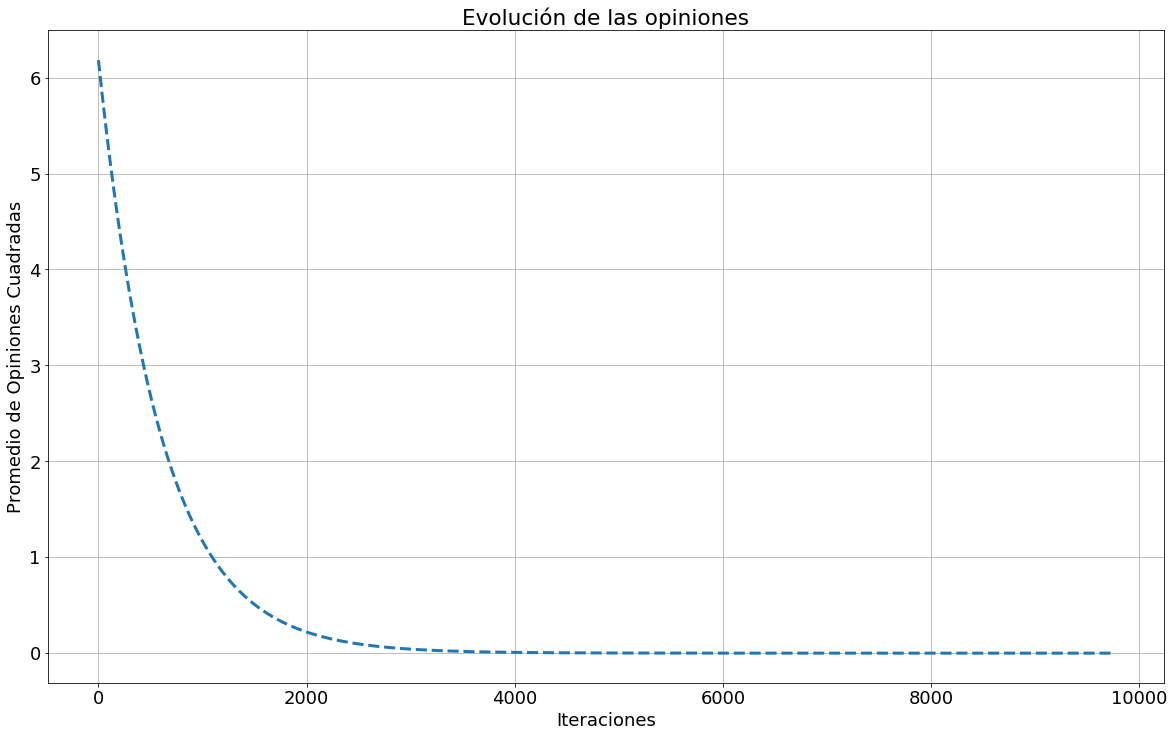

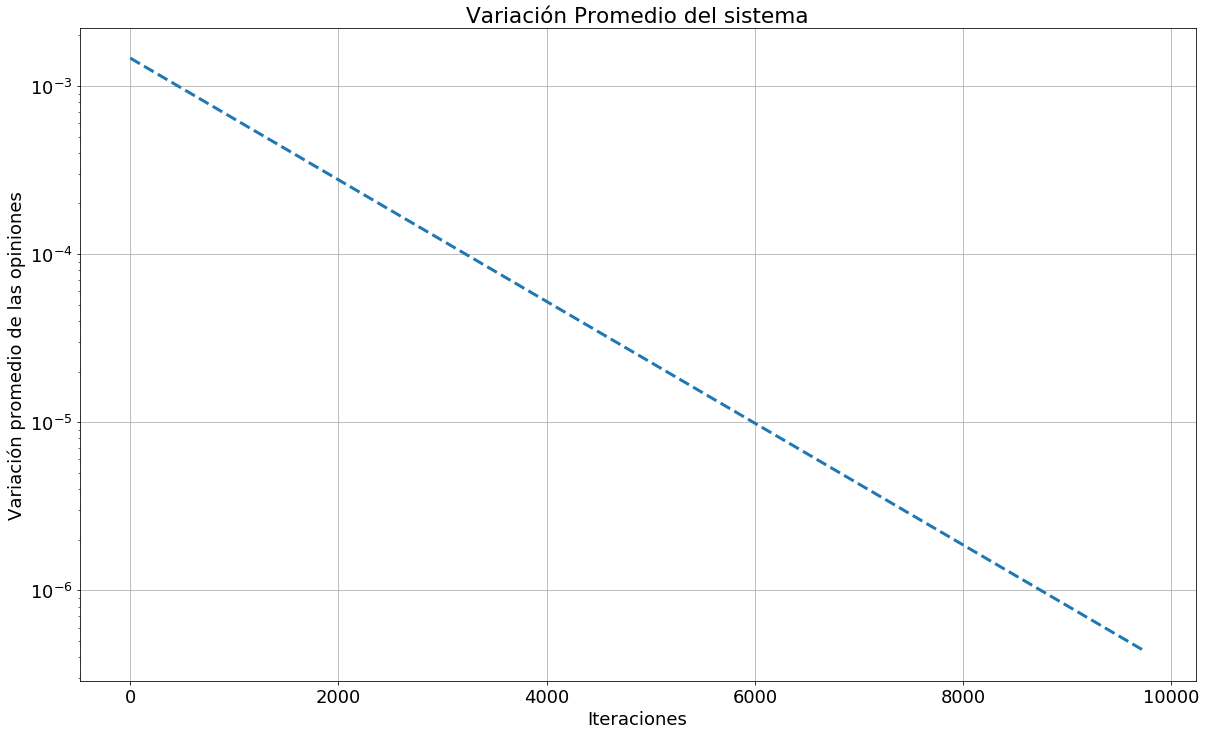

Esto tardó 14.127038478851318 segundos


In [4]:
t0 = time.time()

# En esta celda lo que voy a hacer es mirar los datos que obtuve del programa
# Donde alfa y Delta son las variables. Quiero ver que no haya tocado nada
# raro en el programa y que siga funcionando bien.

#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Grafico Baumann")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#--------------------------------------------------------------------------------------------

# Levanto los datos del archivo original y separo los datos en tres listas.
# Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

Datos = ldata("{}/{}".format(Archivos_Datos[0],Archivos_Datos[1]))

Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
Ady = [int(x) for x in Ady]

Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
Sup = [float(x) for x in Sup]

# Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
# Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

# Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

#--------------------------------------------------------------------------------------------

# Hagamos un gráfico de estos datos
# La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.
# En otra celda empezaré a ver de hacer un gráfico que registre la trayectoria de la opinión de los agentes.

X = np.arange(0,len(Opi))
T = 2 # Este es el número de tópicos
POC = {} # POC significa Promedio Opiniones Cuadradas.
for j in range(T):
    # Obtengo los valores cuadrados de todos mis tópicos
    POC[j] = []
    for i in range(len(Opi)):
        # TS es Tópicos Separados. Esta lista va a ir tomando todas las opiniones de un cierto tópico en una iteración
        TS = [t**2 for t in Opi[i][j:len(Opi[i]):T]]
        # Ahora los sumo y los agrego a mis vectores Y
        POC[j].append(np.sum(TS)/len(TS))


# El vector X con el número de iteraciones, así como el diccionario que guarda las opiniones de cada tópico por
# separado funcionan correctamente. Ahora puedo cambiar el número de tópicos de mi sistema sin dramas.

# -------------------------------------------------------------------------------------------

# Hay que ver la forma de graficar esto correctamente, sin que estalle en términos de cantidad de
# cosas graficadas, y que permita entenderse


YT = np.zeros(len(Opi))
for j in range(T):
    YT += np.array(POC[j])

plt.figure(figsize=(20,12))
plt.plot(X,YT, "--", linewidth = 3)
plt.rcParams.update({'font.size': 18})
plt.xlabel("Iteraciones")
plt.ylabel("Promedio de Opiniones Cuadradas")
plt.title("Evolución de las opiniones")
plt.grid()
plt.show()

#-------------------------------------------------------------------------------------------------

# Acabo de caer en la cuenta que aunque no guarde los datos de las variaciones,
# puedo calcularlas, total tengo todos los datos de opiniones del sistema. El renglón de
# Var define la lista por comprensión.

Var = [math.sqrt(np.sum(np.array([((x2-x1)**2)/len(Opi[i]) for x1,x2 in zip (Opi[i],Opi[i+1])]))) for i in range(len(Opi)-1)]
X = np.arange(0,len(Var))

N = len(Opi[0])/T

plt.figure(figsize=(20,12))
plt.semilogy(X,Var, "--",label="N={},T={}".format(N,T) ,linewidth = 3)
plt.rcParams.update({'font.size': 18})
plt.xlabel("Iteraciones")
plt.ylabel("Variación promedio de las opiniones")
plt.title("Variación Promedio del sistema")
plt.grid()
plt.show()

# El programa sigue funcionando bárbaro, lo cual es buenísimo. Corta en el momento
# adecuado y el comportamiento es razonbale.



Tiempo()

In [ ]:
# En esta celda voy a analizar los datos obtenidos con el modelo que crea
# la red a partir de un modelo de Erdos-Renyi. Es decir, tengo una red fija
# creada de manera aleatoria con una cierta probabilidad p.

t0=time.time()

#--------------------------------------------------------------------------------------

# Voy a definir una función para usar en esta celda, que me permite asignar
# a cada ángulo un color. La idea es que esta función reciba como datos
# el vector a clasificar y la cantidad de pedacitos en la cual divido los
# 360 grados de la circunferencia. Luego me devuelve un número, que va a ser
# el índice en el cual se halla el color de ese vector. El índice lo uso
# para buscar el color en un vector que previamente voy a definir con
# ciertos valores de colores en cada índice. 
# IMPORTANTE: Esto vale sólo para vectores 2D

def Indice_Color(vector,Divisiones):
    # Primero calculo el ángulo
    Vhor = [1,0] # Este vector representa la horizontal
    vector_unitario = vector/np.linalg.norm(vector)
    Producto_escalar = np.dot(Vhor,vector_unitario)
    Angulo = np.arccos(Producto_escalar)
    
    # Le hago ajuste considerando el cuadrante del vector
    if vector[1] < 0:
        Angulo = 2*math.pi-Angulo
    
    
    # Ahora calculo el valor de división entera y el Resto
    Delta = (2*math.pi)/Divisiones
    Dividendo = Angulo/Delta
    D = math.floor(Dividendo)
    R = Dividendo - D
    
    # Compruebo en qué casillero cae el ángulo y returneo el índice
    if R <= Delta/2:
        return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
    elif R > Delta/2:
        return (D+1)%72 # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    
#----------------------------------------------------------------------------------------------

# Acá lo que voy a hacer es preparar los colores que voy a usar para definir los puntos finales
# de las trayectorias de las opiniones

Divisiones = 72
color=cm.rainbow(np.linspace(0,1,Divisiones))


# Lo que hice acá es definir una ¿lista? que tiene en cada casillero los datos que definen un color.
# Tiene diferenciados 720 colores, es decir que tengo un color para cada región de 0.5 grados. Estas regiones
# las voy a distribuir centrándolas en en cada ángulo que cada color representa. Por lo tanto,
# Los vectores que tengan ángulo entre -0.25º y 0.25º tienen el primer color. Los que tengan entre
# 0.25º y 0.75º tienen el segundo color. Y así. Por tanto yo tengo que hallar una fórmula que para
# cada ángulo le asigne el casillero que le corresponde en el vector de color. Luego, cuando grafique
# el punto, para el color le agrego un input que sea: c = color[n]
    


#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Modelo Erdos-Renyi")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]


#--------------------------------------------------------------------------------------------

# Voy a iterar esto para todos los archivos de datos que tengo

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:

    #--------------------------------------------------------------------------------------------

    # Levanto los datos del archivo original y separo los datos en tres listas.
    # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

    Datos = ldata("{}/{}".format(Archivos_Datos[0],nombre))

    Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
    Ady = [int(x) for x in Ady]

    Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
    Sup = [float(x) for x in Sup]

    # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
    # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
    Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

    # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.
    
    #--------------------------------------------------------------------------------------------

    # Levanto los valores de alfa y Cdelta del nombre de mi archivo. Es importante recordar que mis
    # archivos tienen nombres de la forma: Datos_Opiniones_alfa=$_Cdelta=$_N=$.
    # El valor de T es siempre 2. El valor de N puedo deducirlo sabiendo T.

    alfa = float(nombre.split("_")[2].split("=")[1])
    Cdelta = float(nombre.split("_")[3].split("=")[1])
    T = 2
    N = int(nombre.split("_")[4].split("=")[1])

    # Los valores de alfa, Cdelta, T y N se levantan correctamente
    
    #----------------------------------------------------------------------------------------------
    
    # Estos son los parámetros que definen el tamaño del gráfico, tamaño de la letra y nombres de
    # los ejes.
        
        
    plt.figure(figsize=(20,12))
    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Tópico 1")
    plt.ylabel("Tópico 2")
    plt.title(r"Trayectoria de las opiniones en el espacio de tópicos para $\alpha$={}, Cdelta={} y N={}".format(alfa,Cdelta,N))
    
   #----------------------------------------------------------------------------------------------
    
    
    # Voy a intentar replicar el gráfico de Baumann. Para eso voy a querer graficar la trayectoria
    # de todos los agentes. Como van a ser muchos agentes, me conviene que esas trayectorias se grafiquen
    # con líneas finitas
    
    for agente in range(N):
        OdT = dict() # OdT es Opiniones del Tópico.
        for topico in range(T):
            OdT[topico] = []
            for iteracion in range(len(Opi)):
                OdT[topico].append(Opi[iteracion][agente*T+topico])
    
    # Esto levanta correctamente los valores de las opiniones de los agentes para cada uno de sus tópicos      
    
    #-----------------------------------------------------------------------------------------------
    
    # Como todavía tengo dos tópicos, puedo graficar esto en un plano. Así que ahora voy a hacer
    # un código presuponiendo que la cantidad de tópicos es 2. Sino, esto no debería realizarse.
    # Atento a eso.
    
        plt.plot(OdT[0],OdT[1], color="gray",linewidth = 0.6)
    
    #-------------------------------------------------------------------------------------------------
    
    # Genial, así como está esto ya arma el gráfico de las trayectorias de las opiniones. Ahora, me gustaría
    # colocar puntos marcando el final de mis trayectorias. Empecemos con todos puntos del mismo color.
    # Después le voy a agregar que los puntos tengan un color que se corresponda con el ángulo que
    # forman sus componentes con la horizontal.
    
    # IMPORTANTE: Este código está actuando sobre el mismo plot que antes. Por tanto hay que estar atento
    # a respetar la indentación marcada por el for de "agente". Además el código está variando dinámicamente porque
    # estoy cambiando de lugar el plt.show hasta el final cada vez que agrego algo. Atento a eso considerando
    # que estoy intentando armar estos pedazos de código de forma modular.
        
        indice = Indice_Color([OdT[0][len(OdT[0])-1],OdT[1][len(OdT[1])-1]],Divisiones)
        plt.plot(OdT[0][len(OdT[0])-1],OdT[1][len(OdT[1])-1], "o" ,c = color[indice], markersize=10)
    plt.savefig("../Imagenes/Modelo Erdos-Renyi/Trayectoria de las opiniones_alfa={}_Cdelta={}_N={}.png".format(alfa,Cdelta,N),bbox_inches = "tight")
    plt.close()
    
    # Ya implementé la coloración de cada punto según el ángulo que el vector final forma con la horizontal.
    # Ahora eso no se nota porque 



Tiempo()

In [ ]:
# En esta celda voy a analizar cómo varía el cálculo del sistema a medida que varío
# el valor del dt. La idea es ver si puedo usar dt's más grande al calcular el sistema.
# Poder usar dt's más grande sería copado para poder reducir el tamaño de los archivos y
# más importante, el tiempo que tardo en crear los archivos. Lo que vamos a comparar
# es gráficos de trayectorias, gráficos de Variación promedio y armar un gráfico
# final de cantidad de iteraciones en función de cos(delta) para cada alfa.

t0=time.time()

#--------------------------------------------------------------------------------------

# Voy a definir una función para usar en esta celda, que me permite asignar
# a cada ángulo un color. La idea es que esta función reciba como datos
# el vector a clasificar y la cantidad de pedacitos en la cual divido los
# 360 grados de la circunferencia. Luego me devuelve un número, que va a ser
# el índice en el cual se halla el color de ese vector. El índice lo uso
# para buscar el color en un vector que previamente voy a definir con
# ciertos valores de colores en cada índice. 
# IMPORTANTE: Esto vale sólo para vectores 2D

def Indice_Color(vector,Divisiones):
    # Primero calculo el ángulo
    Vhor = [1,0] # Este vector representa la horizontal
    if np.linalg.norm(vector) != 0 :
        vector_unitario = vector/np.linalg.norm(vector)
        Producto_escalar = np.dot(Vhor,vector_unitario)
        Angulo = np.arccos(Producto_escalar)

        # Le hago ajuste considerando el cuadrante del vector
        if vector[1] < 0:
            Angulo = 2*math.pi-Angulo


        # Ahora calculo el valor de división entera y el Resto
        Delta = (2*math.pi)/Divisiones
        Dividendo = Angulo/Delta
        D = math.floor(Dividendo)
        R = Dividendo - D

        # Compruebo en qué casillero cae el ángulo y returneo el índice
        if R <= Delta/2:
            return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
        elif R > Delta/2:
            return (D+1)%72 # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    else:
        return 0;
    
#----------------------------------------------------------------------------------------------

# Acá lo que voy a hacer es preparar los colores que voy a usar para definir los puntos finales
# de las trayectorias de las opiniones

Divisiones = 72
color=cm.rainbow(np.linspace(0,1,Divisiones))


# Lo que hice acá es definir una ¿lista? que tiene en cada casillero los datos que definen un color.
# Tiene diferenciados 720 colores, es decir que tengo un color para cada región de 0.5 grados. Estas regiones
# las voy a distribuir centrándolas en en cada ángulo que cada color representa. Por lo tanto,
# Los vectores que tengan ángulo entre -0.25º y 0.25º tienen el primer color. Los que tengan entre
# 0.25º y 0.75º tienen el segundo color. Y así. Por tanto yo tengo que hallar una fórmula que para
# cada ángulo le asigne el casillero que le corresponde en el vector de color. Luego, cuando grafique
# el punto, para el color le agrego un input que sea: c = color[n]
    


#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Cambios dt")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Cambios dt
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]


#-------------------------------------------------------------------------------------------
# En sí no planeo armar muchas listas de datos, pero la cosa es que los valores de Alfa
# y dt utilizados varían y me gustaría armar dos conjuntos que me guarden estos valores
# para después poder iterar en estos, ya que voy a estar haciendo varios gráficos a partir
# de mis archivos. Voy a necesitar entonces dos conjuntos, uno para Alfa y otro para dt.

# Es important partir del hecho de que mis archivos llevan por nombre: "Datos_Opiniones_alfa=$_dt=$"

Conjunto_Alfa = []
Conjunto_dt = []

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    alfa = float(nombre.split("_")[2].split("=")[1])
    dt = float(nombre.split("_")[3].split("=")[1])
    Conjunto_Alfa.append(alfa)
    Conjunto_dt.append(dt)
    
Conjunto_Alfa = list(set(Conjunto_Alfa))
Conjunto_dt = list(set(Conjunto_dt))

Conjunto_Alfa.sort()
Conjunto_dt.sort()

# Bien, esto ya me arma el conjunto de Alfas y dt con todos los valores de alfa y dt
# que hay en los archivos.

#--------------------------------------------------------------------------------------------

# Voy a iterar esto para todos los archivos de datos que tengo

plt.figure("Iteraciones vs dt",figsize=(20,12),clear=True)
for ALFA in Conjunto_Alfa:
    plt.figure("Variaciones Promedio",figsize=(20,12),clear=True)
    
    Iteraciones = []
    DT = []
    for nombre in Archivos_Datos[1:len(Archivos_Datos)]:

        #--------------------------------------------------------------------------------------------

        # Levanto los valores de alfa y Cdelta del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Opiniones_alfa=$_dt=$.
        # El valor de T es siempre 2. El valor de N puedo deducirlo sabiendo T.

        alfa = float(nombre.split("_")[2].split("=")[1])
        dt = float(nombre.split("_")[3].split("=")[1])
        Cdelta = 0.2
        T = 2
        N = 100

        # Los valores de alfa, dt, Cdelta, T y N se levantan correctamente

        #--------------------------------------------------------------------------------------------
        
        # Antes de levantar mi archivo de datos, decido si es el alfa correspondiente
        
        if alfa==ALFA:
        
            #--------------------------------------------------------------------------------------------

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Archivos_Datos[0],nombre))

            Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
            Ady = [int(x) for x in Ady]

            Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
            Sup = [float(x) for x in Sup]

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

            # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.


            #----------------------------------------------------------------------------------------------

            # Estos son los parámetros que definen el tamaño del gráfico, tamaño de la letra y nombres de
            # los ejes.


            plt.figure("Trayectoria Opiniones",figsize=(20,12))
            plt.rcParams.update({'font.size': 18})
            plt.xlabel("Tópico 1")
            plt.ylabel("Tópico 2")
            plt.title(r"Trayectoria de las opiniones en el espacio de tópicos para $\alpha$={},dt={}, cos($\delta$)={} y N={}".format(alfa,dt,Cdelta,N))

           #----------------------------------------------------------------------------------------------

            # Voy a intentar replicar el gráfico de Baumann. Para eso voy a querer graficar la trayectoria
            # de todos los agentes. Como van a ser muchos agentes, me conviene que esas trayectorias se grafiquen
            # con líneas finitas

            OdT = dict() # OdT es Opiniones del Tópico.
            for agente in range(N):
                for topico in range(T):
                    OdT[topico+T*agente] = []
                    for iteracion in range(len(Opi)):
                        OdT[topico+T*agente].append(Opi[iteracion][agente*T+topico])

            # Esto levanta correctamente los valores de las opiniones de los agentes para cada uno de sus tópicos.
            # De paso, le agregué ahora que las listas del diccionario no se sobreescriban. Eso me va a permitir
            # graficar los puntos finales sin necesidad de revisar una segunda vez la lista Opi

            #-----------------------------------------------------------------------------------------------

            # Como todavía tengo dos tópicos, puedo graficar esto en un plano. Así que ahora voy a hacer
            # un código presuponiendo que la cantidad de tópicos es 2. Sino, esto no debería realizarse.
            # Atento a eso.
            # Como ahora las listas en el diccionario no se sobreescriben, puedo hacer esto con un for aparte
            # de lo anterior

            for agente in range(N):
                plt.plot(OdT[0+T*agente],OdT[1+T*agente], color="gray",linewidth = 0.6)

            #-------------------------------------------------------------------------------------------------

            # Genial, así como está esto ya arma el gráfico de las trayectorias de las opiniones. Ahora, me gustaría
            # colocar puntos marcando el final de mis trayectorias. Luego de eso guardo la figura y la cierro

            for agente in range(N):
                indice = Indice_Color([OdT[0+T*agente][len(OdT[0])-1],OdT[1+T*agente][len(OdT[1])-1]],Divisiones)
                plt.plot(OdT[0+T*agente][len(OdT[0])-1],OdT[1+T*agente][len(OdT[1])-1], "o" ,c = color[indice], markersize=10)

            plt.savefig("../Imagenes/Cambios dt/Trayectoria de las opiniones_alfa={}_dt={}_Cdelta={}_N={}.png".format(alfa,dt,Cdelta,N),bbox_inches = "tight")
            plt.close("Trayectoria Opiniones")

            #-------------------------------------------------------------------------------------------------

            # Esta fue la sección del gráfico de trayectorias de Opiniones, ahora debería hacer el gráfico de
            # Variación Promedio de opiniones

            #-------------------------------------------------------------------------------------------------

            # Acabo de caer en la cuenta que aunque no guarde los datos de las variaciones,
            # puedo calcularlas, total tengo todos los datos de opiniones del sistema. El renglón de
            # Var define la lista por comprensión.

            Var = [math.sqrt(np.sum(np.array([((x2-x1)**2)/len(Opi[i]) for x1,x2 in zip (Opi[i],Opi[i+1])]))) for i in range(len(Opi)-1)]
            
            
            # Para algunos valores de dt me ocurre que el sistema llega a valores de variación cero muy rápido.
            # Eso en el gráfico de logaritmo lo único que ahce es incluir muchos valores del eje x en los
            # cuales no hay nada graficado. Comprimiendo de manera artificial mi gráfico a la izquierda, y 
            # dificultando por tanto su lectura. Por ello es que al Var le voy a cortar todo valor que tenga
            # a partir de que uno de sus valores se haga cero
            for i in range(len(Var)):
                if Var[i]==0:
                    break
            Var = Var[0:i]
            
            X = np.arange(0,len(Var))*dt

            plt.figure("Variaciones Promedio")
            plt.semilogy(X,Var, "--",label=r"dt={},N={},cos($\delta$)={}".format(dt,N,Cdelta) ,linewidth = 3)
            
            # El programa sigue funcionando bárbaro, lo cual es buenísimo. Corta en el momento
            # adecuado y el comportamiento es razonbale. El guardado y el cerrado de la figura
            # lo dejo para el final del for de nombres. El tema de eso es que entonces
            # tengo que iniciar el siguiente gráfico antes de cerrar este. Eso no es un problema
            # para el código o de hacer, es sólo un tema de que dificulta un poquito más la modularidad
            # del código porque ahora las cosas se mezclan y el cierre de este módulo está al final
            
            #--------------------------------------------------------------------------------------------------
            
            # Con esto ya tengo hecho el gráfico de las variaciones promedios. Sólo necesita iterarse en todos
            # los dt para que esté hecho y se guarde. Ahora me queda entonces armar un gráfico de iteraciones 
            # en función de cos(delta) para cada alfa
            
            #--------------------------------------------------------------------------------------------------
            
            # Para este gráfico lo que voy a tener que hacer es construir mis dos vectores de valores, el de iteraciones
            # y el de DT asociado. Así que, primero que nada, voy a necesitar tener las listas creadas. Eso
            # lo voy a tener que crear en el mismo for de ALFA. Lo segundo es que esa lista no se va a armar de manera
            # ordenada. Eso es una cagada si quiero hacer el gráfico con líneas. Así que voy a tener que organizar eso,
            # fuera del for de nombres, para que todo vaya en orden creciente.
            
            Iteraciones.append(len(Opi))
            DT.append(dt)
            
            # Esto ya me arma las listas que quiero. Era muy simple la cosa
            
            #-----------------------------------------------------------------------------------------------
            
    # Ahora ordeno las listas de Iteraciones y DT. Los nombres raros que uso acá se deben a que los nombres clásicos
    # para estas variables ya están siendo usados, entonces necesito ir dándole alguna variante al nombre que me
    # distinga para qué lo uso, y que no me sobreescriba algo ya existente
    
    Xdt = list(Conjunto_dt)
    Xdt.sort()
    Yit = []
    
    for xdt in Xdt:
        for dete,It in zip(DT,Iteraciones):
            if dete==xdt:
                Yit.append(It-2000)
    
    # Esto ya me arma correctamente mis valores a graficar, ahora sólo tengo que ponerlos todos en un sólo gráfico
    
    plt.figure("Iteraciones vs dt")
    plt.loglog(Xdt,Yit,"--",label=r"$\alpha$={}".format(ALFA),linewidth = 3)
    
    # Esto me arma el gráfico de Iteraciones vs paso temporal

    #------------------------------------------------------------------------------------------------------------------
            
    # Esto me guarda el gráfico de variaciones Promedio
    plt.figure("Variaciones Promedio")
    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Tiempo Simulado")
    plt.ylabel("Variación promedio de las opiniones")
    plt.axis("tight")
    plt.title(r"Variación Promedio del sistema con $\alpha$={}".format(ALFA))
    plt.legend()
    plt.grid()
    plt.savefig("../Imagenes/Cambios dt/Variaciones Promedio_alfa={}.png".format(ALFA,Cdelta,N),bbox_inches = "tight")
    plt.close("Variaciones Promedio")
    
    #------------------------------------------------------------------------------------------------------------------

# Esto me guarda el gráfico de Iteraciones vs dt    

plt.figure("Iteraciones vs dt")
plt.legend()
plt.grid()
plt.xlabel("dt")
plt.ylabel("Iteraciones")
plt.rcParams.update({'font.size': 18})
plt.title("Cantidad de iteraciones vs paso temporal")
plt.savefig("../Imagenes/Cambios dt/Iteraciones vs dt.png",bbox_inches = "tight")
plt.close("Iteraciones vs dt")


Tiempo()

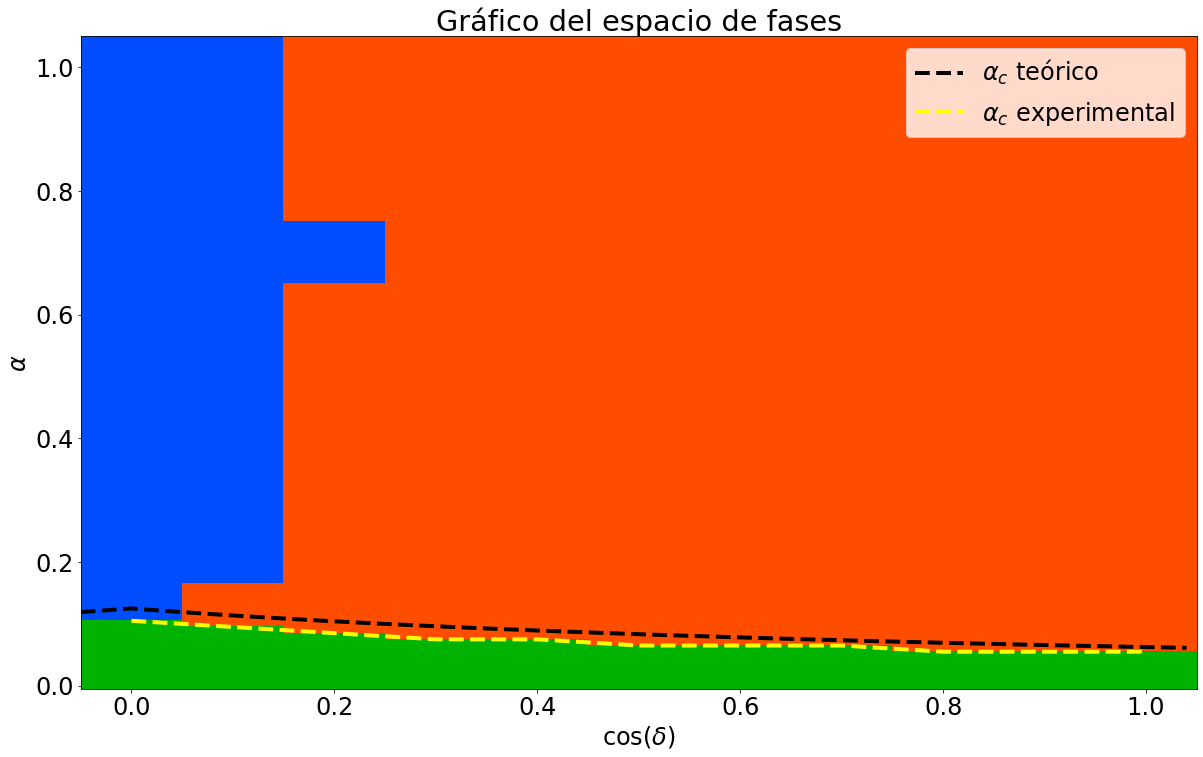

Esto tardó 0.4816763401031494 segundos


In [4]:
# En esta celda lo que voy a hacer es armar los gráficos de Trayectorias de Opiniones (TdO)
# para las simulaciones hechas con N=100 y N=1000 agentes, con dt = 0,1. Esas simulaciones están
# hechas sobre redes estáticas Erdós Renyi con grado medio 8, con CritCorte = 10^(-8) o 10^(-6).
# Lo importante es que tengo 40 simulaciones hechas para cada valor de Alfa y Delta y mi intención
# es graficar los datos de esas 40 simulaciones en un sólo gráfico.

# Después de eso la idea es tomar todos estos datos y empezar a armar el gráfico del comportamiento
# del sistema en el espacio de fases en función de alfa y delta.

t0=time.time()

T=2 # Tengo que definir el número de tópicos en algún lado, lo hago ahora porque más adelante no tiene lugar

#--------------------------------------------------------------------------------------

# Defino primero mi función de AlfaC

def AlfaC(x):
    T = 2 # Número de tópicos
    GM = 8 # Grado medio
    K = 1 # Influencia social
    if(x>0):
        alfa = (T-1)/((GM*K)*(T-1+x))
    else:
        alfa = (T-1)/((GM*K)*(T-1-x))
    return alfa

# Ya probé la función y ahora sí calcula perfecto. Hubo un pequeño
# error al principio.

#------------------------------------------------------------------


# Voy a definir una función para usar en esta celda, que me permite asignar
# a cada ángulo un color. La idea es que esta función reciba como datos
# el vector a clasificar y la cantidad de pedacitos en la cual divido los
# 360 grados de la circunferencia. Luego me devuelve un número, que va a ser
# el índice en el cual se halla el color de ese vector. El índice lo uso
# para buscar el color en un vector que previamente voy a definir con
# ciertos valores de colores en cada índice. 
# IMPORTANTE: Esto vale sólo para vectores 2D

def Indice_Color(vector,Divisiones):
    # Primero calculo el ángulo
    Vhor = [1,0] # Este vector representa la horizontal
    if np.linalg.norm(vector) != 0 :
        vector_unitario = vector/np.linalg.norm(vector)
        Producto_escalar = np.dot(Vhor,vector_unitario)
        Angulo = np.arccos(Producto_escalar)

        # Le hago ajuste considerando el cuadrante del vector
        if vector[1] < 0:
            Angulo = 2*math.pi-Angulo


        # Ahora calculo el valor de división entera y el Resto
        Delta = (2*math.pi)/Divisiones
        Dividendo = Angulo/Delta
        D = math.floor(Dividendo)
        R = (Dividendo - D) * Delta

        # Compruebo en qué casillero cae el ángulo y returneo el índice
        if R <= Delta/2:
            return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
        elif R > Delta/2:
            return (D+1)%Divisiones # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    else:
        return 0;
    
#----------------------------------------------------------------------------------------------

# Voy a definir una función que tome un estado del sistema y a partir de las opiniones
# de los agentes pueda determianr si el sistema se encuentra en un estado de Consenso,
# Polarización Descorrelacionada o Estado ideológico. La idea es que la función reciba
# el estado final del sistema y a partir de este devuelva un string que defina en cual
# de mis tres estados me encuentro. Básicamente la idea de esto es que si mis opiniones
# están muy cerca del cero, entonces estoy en consenso porque ese cae al cero fuerte.
# Entonces pedir que el máximo sea menor a 0,1 es en sí una cota bastante generosa.
# Por el otro lado, el estado ideológico me deja valores sobre una sola diagonal,
# entonces si el producto de la opinión del tópico 1 con la del tópico 2 para
# todos los agentes me da con un único signo, estoy en el caso de estado ideológico.
# Finalmente, si algunos de estos productos me dan positivos y otros negativos,
# entonces estoy en Polarización Descorrelacionada.

def EstadoFinal(Array):
    
    
    # Primero veo el caso de que hayan tendido a cero
    
    ArrayAbs = np.absolute(Array)
    if max(ArrayAbs)<0.01:
        return "Consenso"
    
    #----------------------------------------------------------
    # Ahora veamos los otros dos casos. Primero voy a armar
    # un array que tenga las opiniones del tópico 1, y otro
    # con las opiniones del tópico 2.
    
    ArrayT1 = Array[0:len(Array):2]
    ArrayT2 = Array[1:len(Array):2]
    
    ArrayProd = np.multiply(ArrayT1,ArrayT2)
    for producto in ArrayProd[1:len(ArrayProd)-1]:
        if producto*ArrayProd[0]<0:
            return "Polarizacion"
    
    return "Ideologico"

# Lo probé con algunos vectores de prueba y parece funcar bárbaro. Habrá que probar
# más en detalle. Se me ocurre usar esto para que los gráficos estén etiquetados y
# mirar si en alguno se equivoca.

#-----------------------------------------------------------------------------------------------

# Acá lo que voy a hacer es preparar los colores que voy a usar para definir los puntos finales
# de las trayectorias de las opiniones

Divisiones = 144
color=cm.rainbow(np.linspace(0,1,Divisiones))


# Lo que hice acá es definir una ¿lista? que tiene en cada casillero los datos que definen un color.
# Tiene diferenciados 144 colores, es decir que tengo un color para cada región de 2.5 grados. Estas regiones
# las voy a distribuir centrándolas en en cada ángulo que cada color representa. Por lo tanto,
# Los vectores que tengan ángulo entre -1.25º y 1.25º tienen el primer color. Los que tengan entre
# 1.25º y 3.75º tienen el segundo color. Y así. Por tanto yo tengo que hallar una fórmula que para
# cada ángulo le asigne el casillero que le corresponde en el vector de color. Luego, cuando grafique
# el punto, para el color le agrego un input que sea: c = color[n]
    


#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./ER2")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Cambios dt
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]


#-------------------------------------------------------------------------------------------
# En sí no planeo armar muchas listas de datos, pero la cosa es que los valores de Alfa
# y dt utilizados varían y me gustaría armar dos conjuntos que me guarden estos valores
# para después poder iterar en estos, ya que voy a estar haciendo varios gráficos a partir
# de mis archivos. Voy a necesitar entonces dos conjuntos, uno para Alfa y otro para dt.

# Es importante partir del hecho de que mis archivos llevan por nombre: "Datos_Opiniones_alfa=$_Cdelta=$_N=$_Iter=$"

Conjunto_Alfa = []
Conjunto_Cdelta = []
Conjunto_N = []

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    alfa = float(nombre.split("_")[2].split("=")[1])
    Cdelta = float(nombre.split("_")[3].split("=")[1])
    N = int(nombre.split("_")[4].split("=")[1])
    if alfa not in Conjunto_Alfa:
        Conjunto_Alfa.append(alfa)
    if Cdelta not in Conjunto_Cdelta:
        Conjunto_Cdelta.append(Cdelta)
    if N not in Conjunto_N:
        Conjunto_N.append(N)

Conjunto_Alfa.sort()
Conjunto_Cdelta.sort()
Conjunto_N.sort()


# Bien, esto ya me arma el conjunto de Alfas, Cdelta y N correctamente y ordenados
# Ahora podemos pasar a lo importante de esta celda

#--------------------------------------------------------------------------------------------

# Voy a armar un diccionar que contenga las listas de los nombres de los archivos asociados
# a un cierto N, Alfa y Cdelta. Me armo primero el superdiccionario, que es el diccionario,
# que contiene diccionarios, que llevan a diccionario que llevan a las listas de los nombres
# de los archivos, donde los ingresos a los diccionarios son el número de Agentes, el Alfa
# y el Cdelta respectivos. Entonces la lista se accede sabiendo el Alfa, Cdelta y N
# correspondiente de antemano.

SuperDiccionario = dict()

for AGENTES in Conjunto_N:
    SuperDiccionario[AGENTES] = dict()
    for ALFA in Conjunto_Alfa:
        for CDELTA in Conjunto_Cdelta:
            for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
                alfa = float(nombre.split("_")[2].split("=")[1])
                Cdelta = float(nombre.split("_")[3].split("=")[1])
                N = int(nombre.split("_")[4].split("=")[1])
                if N==AGENTES and alfa==ALFA and Cdelta==CDELTA:
                    if alfa not in SuperDiccionario[AGENTES].keys():
                        SuperDiccionario[AGENTES][ALFA] = dict()
                    if Cdelta not in SuperDiccionario[AGENTES][ALFA].keys():
                        SuperDiccionario[AGENTES][ALFA][CDELTA] = []
                    else:
                        break
                
            

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    alfa = float(nombre.split("_")[2].split("=")[1])
    Cdelta = float(nombre.split("_")[3].split("=")[1])
    N = int(nombre.split("_")[4].split("=")[1])
    SuperDiccionario[N][alfa][Cdelta].append(nombre)
    
# Ya mejoré el armado del SuperDiccionario de manera de que me cada N tenga los Alfa y cada
# Alfa tenga los Cdelta correspondientes. Antes me pasaba que el Conjunto_Alfa era el conjunto
# de TODOS los Alfas que hubiera entre todos los archivos, entonces si algún N tenía
# Alfas que el otro no, eso podía generar problemas. Ahora, como cada diccionario
# armado para cada N tiene por keys sólo los Alfas de ese N, puedo usar eso para
# definir el Conjunto_Alfa de cada N y evitar los problemas que había visto que
# iban a aparecer al querer graficar el mapa de colores de los estados finales del N=1000
    
#--------------------------------------------------------------------------------------------
    
# Empiezo iterando el N desde acá porque lo que voy a hacer es que al iniciar
# la iteración en N, defino mis Conjunto_Alfa y Conjunto_Cdelta en función de
# las keys de mi SuperDiccionario.
    
for AGENTES in [100]:
    
    Conjunto_Alfa = list(SuperDiccionario[AGENTES].keys())
    
    Conjunto_Cdelta = list(SuperDiccionario[AGENTES][Conjunto_Alfa[0]].keys())

    # Primero me armo los grid para el gráfico de las fases. Para eso
    # primero tengo que armarme un array y con el np.meshgrid armarme 
    # los grids del pcolormesh.
    
    Conjunto_Alfa.reverse() # Lo invierto para que me quede el uno arriba y no abajo
    
    x = np.array(Conjunto_Cdelta)
    y = np.array(Conjunto_Alfa)
    
    Conjunto_Alfa.reverse() # Lo vuelvo a invertir para que de nuevo esté como siempre.
    
    XX,YY = np.meshgrid(x,y)
    
    ZZ = np.zeros(XX.shape)
    
    # Con esto ya tengo armados los grids de XX,YY y de paso me armo el grid
    # del ZZ para ir rellenándolo a medida que corro todo el programa, o usando
    # los datos que ya guardé de antes. Para eso es el módulo siguiente
    
    #---------------------------------------------------------------------------------------------
    
    # Levanto los datos del csv usando el pandas y luego paso los datos al ZZ
    
    #DF = pd.read_csv("Grafico Fases N={}.csv".format(AGENTES),delimiter = ",",header = None)
    #
    #if DF.shape == ZZ.shape:
    #    for fila in range(ZZ.shape[0]):
    #        for columna in range(ZZ.shape[1]):
    #            ZZ[fila,columna] = DF.iloc[fila,columna]
    #else:
    #    print("Hubo problemas con el ZZ.")
        
    # Con esto tengo armado el ZZ usando los datos del archivo que ya había armado antes.
    
    #---------------------------------------------------------------------------------------------

    # Voy a iterar esto para todos los archivos de datos que tengo
    
    for ALFA,ialfa in zip(Conjunto_Alfa,np.arange(len(Conjunto_Alfa))):
        
        # Abro el gráfico de Distribución de Opiniones Finales.
        
        plt.figure("Distribucion de Valores",figsize=(20,12))
        
        for CDELTA,icdelta in zip(Conjunto_Cdelta,np.arange(len(Conjunto_Cdelta))):
            
            #-----------------------------------------------------------------------------------
            
            # Abro mis gráficos, creo listas que voy a llenar con todas las simulaciones y armo algunas cosas varias
            # que voy a necesitar para después
            
            plt.figure("Trayectoria Opiniones",figsize=(20,12))
            plt.figure("Variaciones Promedio",figsize=(20,12))
            OpinionesFinales = np.array([])
            Colores2 = cm.rainbow(np.linspace(0,1,len(SuperDiccionario[AGENTES][ALFA][CDELTA])))
            
            #-------------------------------------------------------------------------------------
            for nombre,numero in zip (SuperDiccionario[AGENTES][ALFA][CDELTA],np.arange(len(SuperDiccionario[AGENTES][ALFA][CDELTA]))):

                #--------------------------------------------------------------------------------------------

                # Levanto los datos del archivo original y separo los datos en tres listas.
                # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

                Datos = ldata("{}/{}".format(Archivos_Datos[0],nombre))

#                Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
#                Ady = [int(x) for x in Ady]
#
#                Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
#                Sup = [float(x) for x in Sup]

                # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
                # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
                Opi = np.zeros((len(Datos[5::]),len(Datos[5])-1))
                for fila,ifila in zip (Datos[5::],np.arange(len(Datos[5::]))):
                    Opi[ifila] = fila[1::]

                # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

                #----------------------------------------------------------------------------------------------

                # Acabo de caer en la cuenta que aunque no guarde los datos de las variaciones,
                # puedo calcularlas, total tengo todos los datos de opiniones del sistema. El renglón de
                # Var define la lista por comprensión.

                Var = [math.sqrt(np.sum((Opi[i+1]-Opi[i])*(Opi[i+1]-Opi[i])*(1/len(Opi[i])))) for i in range(Opi.shape[0]-1)]


                # Para algunos valores de dt me ocurre que el sistema llega a valores de variación cero muy rápido.
                # Eso en el gráfico de logaritmo lo único que ahce es incluir muchos valores del eje x en los
                # cuales no hay nada graficado. Comprimiendo de manera artificial mi gráfico a la izquierda, y 
                # dificultando por tanto su lectura. Por ello es que al Var le voy a cortar todo valor que tenga
                # a partir de que uno de sus valores se haga cero
                
                for i in range(len(Var)):
                    if Var[i]==0:
                        break
                Var = Var[0:i]

                X = np.arange(0,len(Var))*0.1 # El dt usado en todos los archivos es 0.1

                plt.figure("Variaciones Promedio")
                plt.semilogy(X,Var, "--",c = Colores2[numero],linewidth = 2)

                # El programa sigue funcionando bárbaro, lo cual es buenísimo. Corta en el momento
                # adecuado y el comportamiento es razonbale. El guardado y el cerrado de la figura
                # lo dejo para el final del for de nombres. El tema de eso es que entonces
                # tengo que iniciar el siguiente gráfico antes de cerrar este. Eso no es un problema
                # para el código o de hacer, es sólo un tema de que dificulta un poquito más la modularidad
                # del código porque ahora las cosas se mezclan y el cierre de este módulo está al final

                #--------------------------------------------------------------------------------------------------
                
                
                # Acá voy a calcular al sujeto que voy a usar para normalizar mis gráficos. Tiene que ser el máximo
                # valor de opinión que haya alcanzado cualquier sujeto en cualquier momento.
                
                MaxNorm = 0
                for Opiniones in Opi:
                    MaxNorm = max(MaxNorm,max(np.absolute(Opiniones)))
                MaxNorm = 1/MaxNorm
                
                # Esto funciona perfecto. El único tema a considerar es que este valor MaxNorm se traspasa
                # a otros módulos, entonces eso hace que esos módulos no sean tan independientes. En particular
                # me refiero al módulo que construye el diccionario OdT y el que arma la lista de puntos
                # finales PuntosFinales. Supongo que esto se podría solucionar directamente normalizando el 
                # vector de opiniones. Entonces los otros trabajaría por su cuenta sin mezclar cosas
                # de módulos que podrían no copiarse en futuros códigos.
                
                #-----------------------------------------------------------------------------------------------

                # Como todavía tengo dos tópicos, puedo graficar esto en un plano. Así que ahora voy a hacer
                # un código presuponiendo que la cantidad de tópicos es 2. Sino, esto no debería realizarse.
                # Atento a eso.
                # Como ahora las listas en el diccionario no se sobreescriben, puedo hacer esto con un for aparte
                # de lo anterior

                plt.figure("Trayectoria Opiniones")
                for agente in range(AGENTES):
                    plt.plot(Opi[::,0+T*agente]*MaxNorm,Opi[::,1+T*agente]*MaxNorm, color="gray",linewidth = 0.6, alpha=0.2)
                    
                #-------------------------------------------------------------------------------------------------
                
                # Ahora lo que voy a hacer es tomar el estado final del sistema y usar la función EstadoFinal
                # para determinar si el sistema llegó a un Consenso, Polarización o Estado Ideológico.
                
                OpinionesFinales = np.concatenate((OpinionesFinales,Opi[len(Opi)-1]), axis=None)
                
                # Con esto me armo la lista de estados finales de mi sistema
                
            #-------------------------------------------------------------------------------------------------

            # Genial, así como está esto ya arma el gráfico de las trayectorias de las opiniones. Ahora, me gustaría
            # colocar puntos marcando el final de mis trayectorias.

            plt.figure("Trayectoria Opiniones")
            for x1,x2 in zip (OpinionesFinales[0::2]*MaxNorm,OpinionesFinales[1::2]*MaxNorm):
                indice = Indice_Color(np.array([x1,x2]),Divisiones)
                plt.plot(x1,x2, "o" ,c = color[indice], markersize=10)


            #----------------------------------------------------------------------------------------------

            # Estos son los parámetros que definen el tamaño del gráfico, tamaño de la letra y nombres de
            # los ejes. Luego de eso guardo la figura y la cierro. Esto es para la figura de
            # TdO.
            
            plt.figure("Trayectoria Opiniones")
            plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
            plt.rcParams.update({'font.size': 24})
#            plt.xlabel("Tópico 1")
#            plt.ylabel("Tópico 2")
#            plt.title(r"Trayectoria de las opiniones en el espacio de tópicos para $\alpha$={},cos($\delta$)={} y N={}".format(ALFA,CDELTA,AGENTES))
            xmin,xmax = plt.xlim()
            ymin,ymax = plt.ylim()
            plt.text((xmax+xmin)/2*0.9,ymax*0.9,EstadoFinal(OpinionesFinales), bbox=dict(facecolor='White', alpha=0.7))
            plt.annotate(r"$\alpha$={},cos($\delta$)={},N={}".format(ALFA,CDELTA,AGENTES), xy=(0.75,0.95),xycoords='axes fraction',fontsize=20,bbox=dict(facecolor='White', alpha=0.7))
            plt.savefig("../Imagenes/ER2/Trayectoria de las opiniones_alfa={:.2f}_Cdelta={}_N={}.png".format(ALFA,CDELTA,AGENTES),bbox_inches = "tight")
            plt.close("Trayectoria Opiniones")

            #------------------------------------------------------------------------------------------------
            
            # Esto me guarda el gráfico de variaciones Promedio
            plt.figure("Variaciones Promedio")
            plt.rcParams.update({'font.size': 24})
            plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
#            plt.xlabel("Tiempo Simulado")
#            plt.ylabel("Variación promedio de las opiniones")
#            plt.axis("tight")
#            plt.title(r"Variación Promedio del sistema para $\alpha$={}_cos($\delta$)={}_N={}".format(ALFA,CDELTA,AGENTES))
            plt.annotate(r"$\alpha$={},cos($\delta$)={},N={}".format(ALFA,CDELTA,AGENTES), xy=(0.75,0.95),xycoords='axes fraction',fontsize=20,bbox=dict(facecolor='White', alpha=0.7))
            plt.grid()
            plt.savefig("../Imagenes/ER2/Variaciones Promedio_alfa={:.2f}_Cdelta={}_N={}.png".format(ALFA,CDELTA,AGENTES),bbox_inches = "tight")
            plt.close("Variaciones Promedio")
            
            #-------------------------------------------------------------------------------------------------
        
        
            # Acá lo que voy a hacer es rellenar el grid de ZZ con los valores de los resultados de
            # opiniones finales
            
            ResultadoEF = EstadoFinal(OpinionesFinales)
            EC = [("Consenso",0),("Polarizacion",1),("Ideologico",2)] # EC es Estados y colores. Tiene tuplas con los colores asociados
            
            for estado in EC:
                if ResultadoEF == estado[0]:
                    ZZ[len(Conjunto_Alfa)-1-ialfa, icdelta] = estado[1] 
        
        
            #--------------------------------------------------------------------------------------------------
        
            # Puedo armar acá el gráfico de distribución de valores. Además, para esto puedo usar una lista que
            # ya armé antes que es la de Opiniones Finales. A partir de esta voy a hacer las distribuciones del
            # Tópico 1 y del 2 y eso voy a graficar. Las distribuciones las voy a calcular con el np.histogram.
            # Como tengo 100 agentes y 40 simulaciones, entonces tengo 4000 opiniones para cada tópico. Me parece
            # razonable separar esto en 40 bins.
            
            Histo,Bordes_Bin = np.histogram(OpinionesFinales,bins=30)
            
            EjeX = [(Bordes_Bin[i+1]+Bordes_Bin[i])/2 for i in range(len(Bordes_Bin)-1)]
            
            plt.figure("Distribucion de Valores")
            plt.plot(EjeX,Histo,"--",linewidth = 3, label = r"$cos(\delta)$ = {}".format(CDELTA))
            
        plt.rcParams.update({'font.size': 18})
        plt.xlabel("Valores de Opiniones")
        plt.ylabel("Ocurrencias")
        plt.title(r"Distribucion de las opiniones para $\alpha$={:.2f} y N={}".format(ALFA, AGENTES))
        plt.legend()
        plt.grid()
        plt.savefig("../Imagenes/ER2/Distribución opiniones_N={}_alfa={:.2f}.png".format(AGENTES,ALFA),bbox_inches = "tight")
        plt.close("Distribucion de Valores")
            
        #-----------------------------------------------------------------------------------------------------------
        
    # Acá termino mi gráfico de Fases, una vez que recorrí todos los Alfa y Cdelta.
    
    # Armo mi colormap. Para eso armo una lista con los colores que voy a usar,
    # los cuales son una tuplas de tres elementos que combinan colores en proporción
    # donde el primer número es el color rojo, el segundo el verde y el tercero el azul.
    # Con eso luego uso la función de LinearSegmentedeColormap para que me traduzca
    # mi lista de colores a un colormap, y como sólo voy a graficar tres valores
    # en N pongo un 3 para separar el binneado de mi mapa de colores en sólo 3.
    # Luego le mando ese colormap al pcolormesh y listo.
    
    
    colors = [(0, 0.7, 0), (0, 0.3, 1), (1, 0.3, 0)]  #  R -> G -> B 
    cmap_name = 'Mi_lista'
    ColMap = LinearSegmentedColormap.from_list(cmap_name, colors, N=3)
    
    # Defino los parámetros usuales de mi gráfico
    
    plt.figure("Espacio parametros",figsize=(20,12))
    plt.rcParams.update({'font.size': 24})
    plt.xlabel(r"cos($\delta$)")
    plt.ylabel(r"$\alpha$")
    plt.title("Estados finales en el espacio de parametros")
    
    # Grafico la línea del Alfa Crítico teórico
    
    Xa = np.arange(-0.05,1.05,0.01)
    Ya = np.array([AlfaC(x) for x in Xa])
    plt.plot(Xa,Ya,"--",color = "black",linewidth = 4, label = r"$\alpha_c$ teórico")
    
    # Armo el gráfico del Alfa Crítico experimental
    
    Xb = Conjunto_Cdelta
    Yb = []
    
    for columna in range(ZZ.shape[1]):
        for fila in range(ZZ.shape[0]-1):
            if ZZ[fila,columna]!=0 and ZZ[fila+1,columna]==0:
                Yb.append((YY[fila,columna]+YY[fila+1,columna])/2)
                break
                
    plt.plot(Xb,Yb,"--",color = "yellow",linewidth = 4, label = r"$\alpha_c$ experimental")
    
    # Hago el ploteo del mapa de colores con el colormesh y usando el mapa de colroes creado por mi.
    
    plt.legend()
    plt.pcolormesh(XX,YY,ZZ,shading="nearest", cmap = ColMap)
    plt.savefig("../Imagenes/ER2/Estados finales EP.png", bbox_inches = "tight")
    plt.close("Espacio parametros")
    
    #---------------------------------------------------------------------------------------------------
    
    # Me falta guardar los valores de ZZ en un archivo, por si necesito hacerle un retoque al archivo y no 
    # quiero volver a correr todo de una
    
    np.savetxt("Grafico Fases N={}.csv".format(AGENTES), ZZ, delimiter = ",")


# -------------------------------------------------------------------------------------------------
       
        
Tiempo()

In [6]:
# En esta celda lo que voy a hacer es tomar algunos gráficos realizados antes
# y usarlos para armar un gráfico más grande comparativo. Mi idea es comparar
# las TdO y las Variaciones Promedio para una serie de valores de alfa y Cdelta:
# Alfa = [0; 0,05; 0,1; 0,15; 0,2; 0,3; 0,4]
# Cdelta = [0; 0,2; 0,4; 0,6; 0,8; 1]
# Lo que tengo que hacer entonces es tomar los nombres de los archivos correspondientes.
# Luego, levantar las imágenes con imread, graficarlas y guardar la imagen.

t0 = time.time()

# Estos Alfa y Cosdelta los elegí arbitrariamente

Lista_Alfa = []

#------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("../Imagenes/RedAct")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Cambios dt
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#-------------------------------------------------------------------------------------------

# Ahora me armo la lista de los nombres de los archivos que voy a graficar.
# Recordá que los nombres de los archivos de opiniones son:
# "Grafico_opiniones_alfa=$_Cdelta=$_N=$_Iter=$.png". En cambio los de tópicos son:
# "Topicos_alfa=$_Cdelta=$_N=$_Iter=$.png" También están dando vueltas los archivos:
# "Distribución opiniones_N=$_añfa=$.png"

Nombres_Opiniones= []
Nombres_Topicos = []

# Esto es el código original

# for ALFA in Lista_Alfa:
#     for CDELTA in Lista_Cdelta:
#         for nombre in Archivos_Datos[1::]:
#             tipo = nombre.split("_")[0]
#             if tipo=="Grafico":
#                 alfa = float(nombre.split("_")[2].split("=")[1])
#                 cdelta = float(nombre.split("_")[3].split("=")[1])
#                 n = int(nombre.split("_")[4].split("=")[1])
#                 if alfa not in Lista_Alfa:
#                     Lista_Alfa.append(alfa)
#                 if alfa == ALFA and cdelta == CDELTA and n == 1000:
#                     Nombres_Opiniones.append(nombre)
#             if tipo=="Topicos":
#                 alfa = float(nombre.split("_")[1].split("=")[1])
#                 cdelta = float(nombre.split("_")[2].split("=")[1])
#                 n = int(nombre.split("_")[3].split("=")[1])
#                 if alfa == ALFA and cdelta == CDELTA and n == 1000:
#                     Nombres_Topicos.append(nombre)


# Esta es la versión que trabaja con las redes de Actividad

for nombre in Archivos_Datos[1::]:
    tipo = nombre.split("_")[0]
    if tipo=="Grafico":
        alfa = float(nombre.split("_")[2].split("=")[1])
        if alfa not in Lista_Alfa:
            Lista_Alfa.append(alfa)
        Nombres_Opiniones.append(nombre)
    if tipo=="Topicos":
        Nombres_Topicos.append(nombre)

# Ya tengo correctamente armadas las listas de archivos de Trayectorias y de Variaciones
# para graficar. Ahora sólo tengo que armar los gráficos.

#--------------------------------------------------------------------------------------

# Voy a primero graficar mi tabla de gráficos de TdO. Primero armo mi figura con
# plt.figure. Después le pongo ejes explícitimante con plt.axes() y cambio el tamaño
# de la letra a 40. 

plt.rcParams.update({'font.size': 40})
fig = plt.figure(figsize=(64,36))
# plt.axes()

# Ahora, trabajando sobre los ejes, les pongo nombres al eje X e Y. Defino el tamaño
# de los gráficos que van a estar en mi tabla de gráficos. "a" es el ancho y "b" es
# el alto. Como todos los gráficos utilizados son iguales, o quizás porque el gridspec
# genera espacios iguales, el tamaño de todos los gráficos es el mismo. Además, como
# en la figura general fig no estoy ploteando nada, puedo definir que los límites vayan
# de 0 a 1, la verdad esos es realmente indistinto. Luego, como conozco el tamaño total de
# lo graficado en mi eje X y conozco el tamaño de mis gráficos, simplemente distribuyo los
# ticks en X y en Y sabiendo que los ticks van en el centro de las imágenes, y por tanto
# en X van de [a/2;1-a/2] y en Y van de [b/2;1-b/2]. Por eso uso el linspace para ubicar
# de manera uniforme los ticks

# Esta es la versión original del código
# plt.xlabel(r"cos($\delta$)")
# plt.ylabel(r"$\alpha$")
# a = 1/len(Lista_Cosdelta)
# b = 1/len(Lista_Alfa)
# plt.xticks(np.linspace(a/2,1-a/2,len(Lista_Cosdelta)),Lista_Cosdelta)
# plt.yticks(np.linspace(b/2,1-b/2,len(Lista_Alfa)),Lista_Alfa)
# plt.xlim(0,1)
# plt.ylim(0,1)


# Esta es la versión de las redes de actividad, donde sé que tengo que 
# graficar 40 gráficos y que estos corresponden a un único alfa. Estoy arbitrariamente
# eligiendo graficarlos en 8*5.
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Tabla de Graficos de Opiniones")



# Sobre mi figura general agrego un gridspace usando add.gridspec. Los primeros
# dos argumentos son la cantidad de filas y columnas que tendra la grilla. Además,
# hspace es la separación que tendrán en filas y wspace la separación en columnas.
# Lo pongo en cero porque como voy a graficar muchas cosas juntas, mejor reducir
# el espacio todo lo posible. Sería un tema de mayor preocupación si graficara
# durante la creación de esta figura en vez de simplemente levantar imágenes.
# Lo siguiente es llamar al comando subplots de Gridspace, que me devuelve
# las direcciones de los ejes para graficar lo que necesito.

gs = fig.add_gridspec(4,5,hspace=0,wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

# Finalmente recorro la lista de imágenes que armé previamente y las voy
# ubicando en sus respectivos lugares, es decir sus ejes correspondientes.
# Para esto primero leo la imagen con imread, la ploteo con imshow con
# una interpolación de "spline16" para no perder calidad en la imagen y
# le saco los ejes porque al final del día estas son imágenes de gráficos
# que ya tienen sus propias magnitudes graficadas, ponerles ejes extras 
# es redundante y además confunde y me achica las imágenes.
# Los ejes los completo en filas con len(Lista_Alfa)-1-i porque quiero
# que los gráficos de Alfa Cero vayan abajo de todo y que el Alfa crezca
# con el eje Y.

# Esta es la versión original del código

# for i in range(len(Lista_Alfa)):
#     for j in range(len(Lista_Cosdelta)):
#         img = plt.imread("{}/{}".format(Archivos_Datos[0],Nombres_TdO[i*len(Lista_Cosdelta)+j]))
#         axs[len(Lista_Alfa)-1-i,j].imshow(img, interpolation = "spline16")
#         axs[len(Lista_Alfa)-1-i,j].axis("off")

# Esta es la versión del código que trabaja sobre los gráficos de Redes de Actividad.
Lista_Alfa.sort()
j = 0
i = 0
for ALFA in Lista_Alfa[21::]:
    Graficos = []
    for nombre in Nombres_Opiniones:
        alfa = float(nombre.split("_")[2].split("=")[1])
        if alfa==ALFA:
            Graficos.append(nombre)
    sampleo = random.randint(0,len(Graficos)-1)
    img = plt.imread("{}/{}".format(Archivos_Datos[0],Graficos[sampleo]))
    axs[4-1-i,j].imshow(img, interpolation = "spline16")
    axs[4-1-i,j].axis("off")
    j+=1
    if j == 5:
        j=0
        i+=1
    

# for ax in axs:
#     ax.label_outer()

plt.savefig("../Imagenes/RedAct/Tabla Graficos Opiniones2.png",bbox_inches="tight")
plt.close()

# Ya se me arma el gráfico correctamente. Es importante marcar qué es qué, porque
# acá hay muchos comandos que no acostumbro a usar.

#--------------------------------------------------------------------------------------

# Voy a graficar mi tabla de gráficos de Variaciones Promedio. Primero armo mi figura con
# plt.figure. Después le pongo ejes explícitimante con plt.axes() y cambio el tamaño
# de la letra a 40. 

plt.rcParams.update({'font.size': 40})
fig = plt.figure(figsize=(64,36))
# plt.axes()

# Ahora, trabajando sobre los ejes, les pongo nombres al eje X e Y. Defino el tamaño
# de los gráficos que van a estar en mi tabla de gráficos. "a" es el ancho y "b" es
# el alto. Como todos los gráficos utilizados son iguales, o quizás porque el gridspec
# genera espacios iguales, el tamaño de todos los gráficos es el mismo. Además, como
# en la figura general fig no estoy ploteando nada, puedo definir que los límites vayan
# de 0 a 1, la verdad esos es realmente indistinto. Luego, como conozco el tamaño total de
# lo graficado en mi eje X y conozco el tamaño de mis gráficos, simplemente distribuyo los
# ticks en X y en Y sabiendo que los ticks van en el centro de las imágenes, y por tanto
# en X van de [a/2;1-a/2] y en Y van de [b/2;1-b/2]. Por eso uso el linspace para ubicar
# de manera uniforme los ticks

# Esta es la versión original del código

# plt.xlabel(r"cos($\delta$)")
# plt.ylabel(r"$\alpha$")
# a = 1/len(Lista_Cosdelta)
# b = 1/len(Lista_Alfa)
# plt.xticks(np.linspace(a/2,1-a/2,len(Lista_Cosdelta)),Lista_Cosdelta)
# plt.yticks(np.linspace(b/2,1-b/2,len(Lista_Alfa)),Lista_Alfa)
# plt.xlim(0,1)
# plt.ylim(0,1)

# Esta es la versión del código de Redes de Actividad

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Tabla de Graficos de Topicos")


# Sobre mi figura general agrego un gridspace usando add.gridspec. Los primeros
# dos argumentos son la cantidad de filas y columnas que tendra la grilla. Además,
# hspace es la separación que tendrán en filas y wspace la separación en columnas.
# Lo pongo en cero porque como voy a graficar muchas cosas juntas, mejor reducir
# el espacio todo lo posible. Sería un tema de mayor preocupación si graficara
# durante la creación de esta figura en vez de simplemente levantar imágenes.
# Lo siguiente es llamar al comando subplots de Gridspace, que me devuelve
# las direcciones de los ejes para graficar lo que necesito.

gs = fig.add_gridspec(4,5,hspace=0,wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

# Finalmente recorro la lista de imágenes que armé previamente y las voy
# ubicando en sus respectivos lugares, es decir sus ejes correspondientes.
# Para esto primero leo la imagen con imread, la ploteo con imshow con
# una interpolación de "spline16" para no perder calidad en la imagen y
# le saco los ejes porque al final del día estas son imágenes de gráficos
# que ya tienen sus propias magnitudes graficadas, ponerles ejes extras 
# es redundante y además confunde y además me achica las imágenes.
# Los ejes los completo en filas con len(Lista_Alfa)-1-i porque quiero
# que los gráficos de Alfa Cero vayan abajo de todo y que el Alfa crezca
# con el eje Y.

# Esta es la versión del código original

# for i in range(len(Lista_Alfa)):
#     for j in range(len(Lista_Cosdelta)):
#         img = plt.imread("{}/{}".format(Archivos_Datos[0],Nombres_Variaciones[i*len(Lista_Cosdelta)+j]))
#         axs[len(Lista_Alfa)-1-i,j].imshow(img, interpolation = "spline16")
#         axs[len(Lista_Alfa)-1-i,j].axis("off")

# Esta es la versión del código que trabaja sobre los gráficos de Redes de Actividad.
Lista_Alfa.sort()
j = 0
i = 0
for ALFA in Lista_Alfa[21::]:
    Graficos = []
    for nombre in Nombres_Topicos:
        alfa = float(nombre.split("_")[1].split("=")[1])
        if alfa==ALFA:
            Graficos.append(nombre)
    sampleo = random.randint(0,len(Graficos)-1)
    img = plt.imread("{}/{}".format(Archivos_Datos[0],Graficos[sampleo]))
    axs[4-1-i,j].imshow(img, interpolation = "spline16")
    axs[4-1-i,j].axis("off")
    j+=1
    if j == 5:
        j=0
        i+=1

# for ax in axs:
#     ax.label_outer()

plt.savefig("../Imagenes/RedAct/Tabla Graficos Topicos2.png",bbox_inches="tight")
plt.close()

# Ya se me arma el gráfico correctamente. Es importante marcar qué es qué, porque
# acá hay muchos comandos que no acostumbro a usar.

#----------------------------------------------------------------------------------


Tiempo()

Esto tardó 59.038925647735596 segundos


In [18]:
print(Lista_Alfa)


[0.0, 0.013, 0.025, 0.038, 0.05, 0.062, 0.075, 0.087, 0.1, 0.112, 0.125, 0.138, 0.15, 0.162, 0.175, 0.188, 0.2, 0.213, 0.225, 0.237, 0.25, 0.262, 0.275, 0.287, 0.3, 0.312, 0.325, 0.338, 0.35, 0.363, 0.375, 0.387, 0.4, 0.412, 0.425, 0.438, 0.45, 0.463, 0.475, 0.488, 0.5]


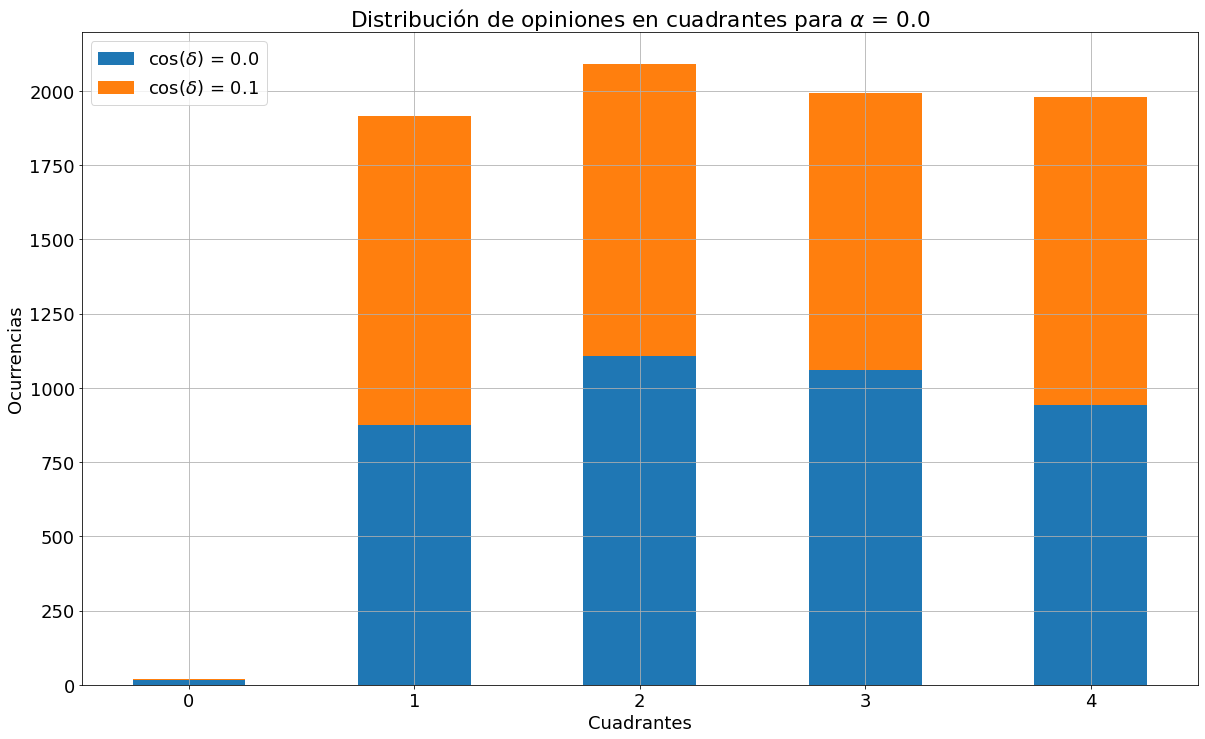

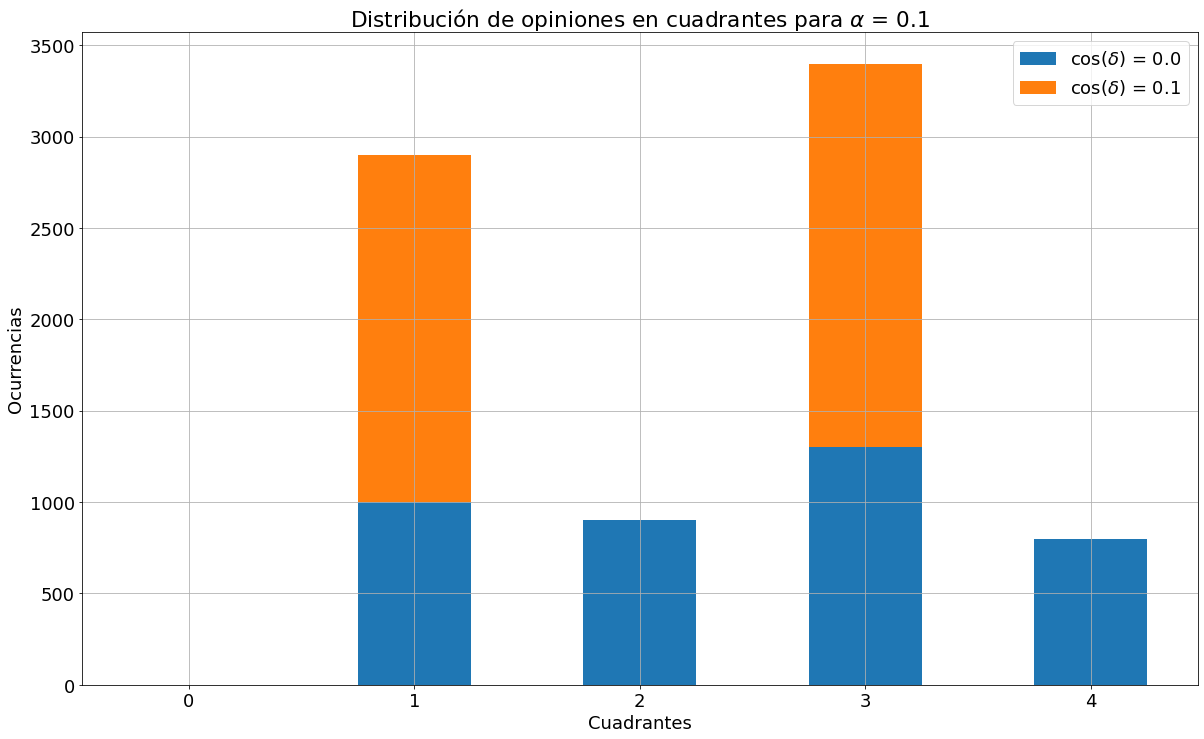

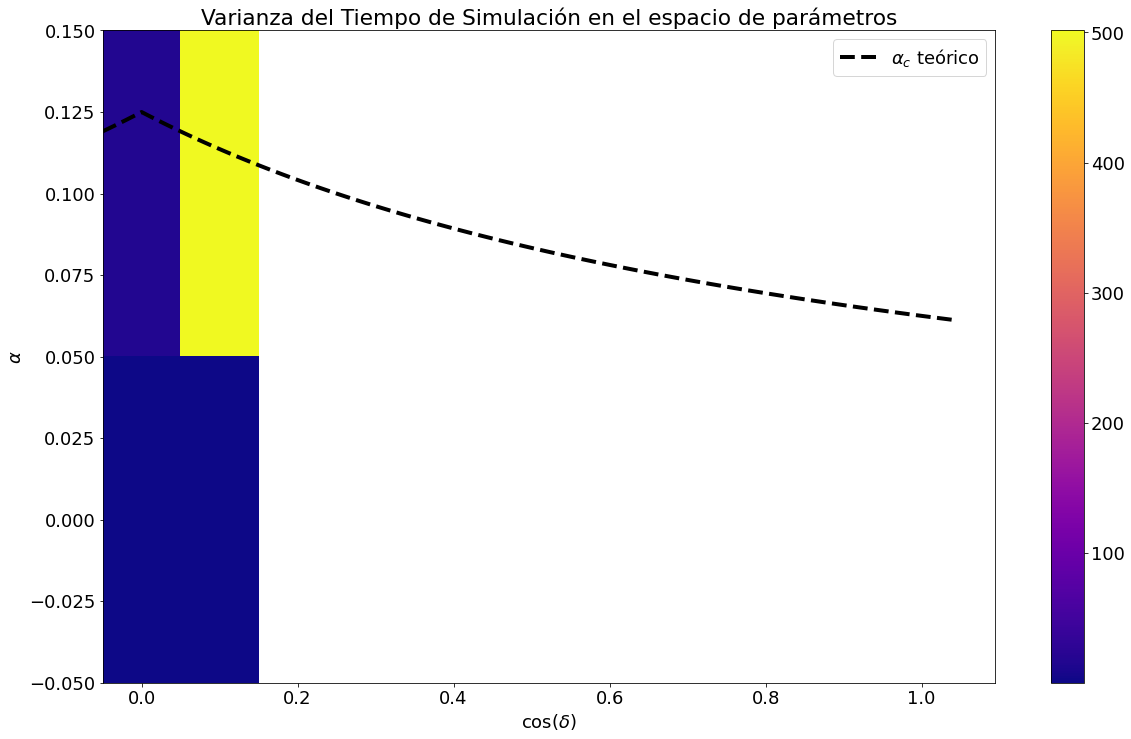

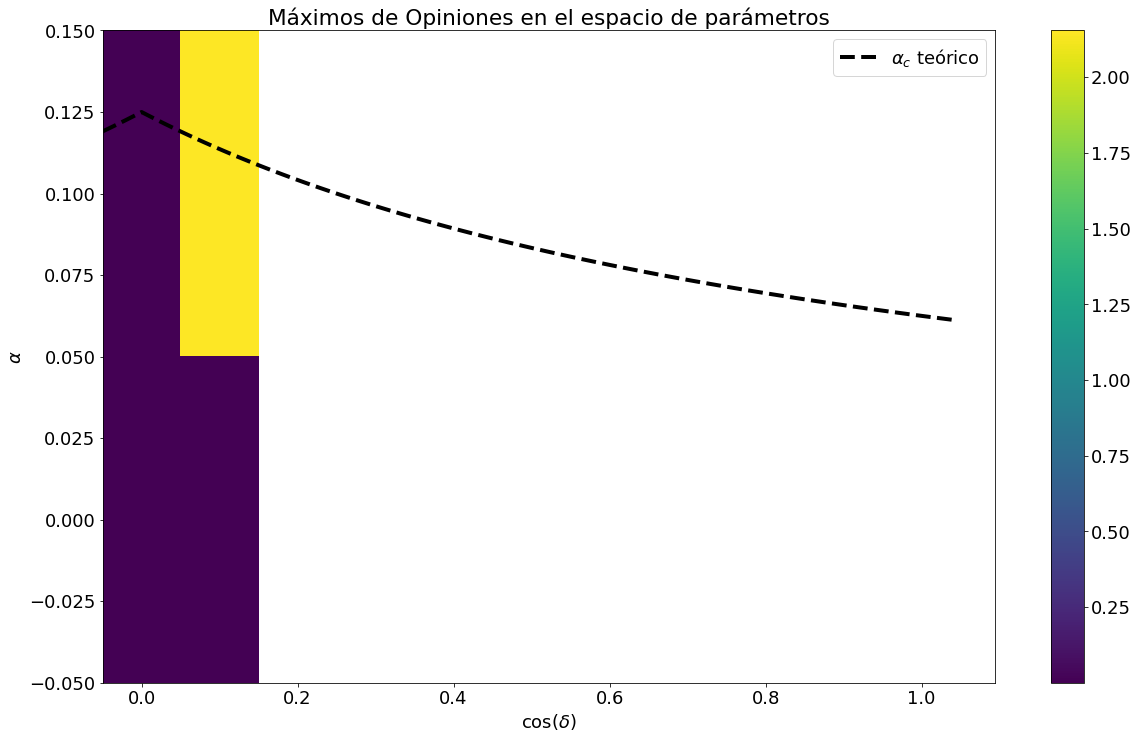

Esto tardó 45.27145314216614 segundos


In [17]:
# En esta celda voy a hacer los análisis de caracterización de la región de transición
# del sistema. Estos análisis son el análisis de la varianza de los tiempos de convergencia,
# La medición de los máximos valores alcanzados por el sistema y la distribución de opiniones
# por cuadrantes. (¿Se podría hacer un plot polar?)

t0=time.time()

T=2 # Tengo que definir el número de tópicos en algún lado, lo hago ahora porque más adelante no tiene lugar


#--------------------------------------------------------------------------------------

# Defino primero mi función de AlfaC

def AlfaC(x):
    T = 2 # Número de tópicos
    GM = 8 # Grado medio
    K = 1 # Influencia social
    if(x>0):
        alfa = (T-1)/((GM*K)*(T-1+x))
    else:
        alfa = (T-1)/((GM*K)*(T-1-x))
    return alfa

# Ya probé la función y ahora sí calcula perfecto. Hubo un pequeño
# error al principio.

#------------------------------------------------------------------


# Voy a definir una función para usar en esta celda, que me permite asignar
# a cada ángulo un color. La idea es que esta función reciba como datos
# el vector a clasificar y la cantidad de pedacitos en la cual divido los
# 360 grados de la circunferencia. Luego me devuelve un número, que va a ser
# el índice en el cual se halla el color de ese vector. El índice lo uso
# para buscar el color en un vector que previamente voy a definir con
# ciertos valores de colores en cada índice. 
# IMPORTANTE: Esto vale sólo para vectores 2D

def Indice_Color(vector,Divisiones):
    # Primero calculo el ángulo
    Vhor = [1,0] # Este vector representa la horizontal
    if np.linalg.norm(vector) != 0 :
        vector_unitario = vector/np.linalg.norm(vector)
        Producto_escalar = np.dot(Vhor,vector_unitario)
        Angulo = np.arccos(Producto_escalar)

        # Le hago ajuste considerando el cuadrante del vector
        if vector[1] < 0:
            Angulo = 2*math.pi-Angulo


        # Ahora calculo el valor de división entera y el Resto
        Delta = (2*math.pi)/Divisiones
        Dividendo = Angulo/Delta
        D = math.floor(Dividendo)
        R = (Dividendo - D) * Delta

        # Compruebo en qué casillero cae el ángulo y returneo el índice
        if R <= Delta/2:
            return D # En este caso el ángulo se encuentra entre (D*Delta-Delta/2,D*Delta+Delta/2]
        elif R > Delta/2:
            return (D+1)%Divisiones # En este caso el ángulo se encuentra entre ((D+1)*Delta-Delta/2,(D+1)*Delta+Delta/2]
    else:
        return 0;
    
#----------------------------------------------------------------------------------------------

# Voy a definir una función que tome un estado del sistema y a partir de las opiniones
# de los agentes pueda determianr si el sistema se encuentra en un estado de Consenso,
# Polarización Descorrelacionada o Estado ideológico. La idea es que la función reciba
# el estado final del sistema y a partir de este devuelva un string que defina en cual
# de mis tres estados me encuentro. Básicamente la idea de esto es que si mis opiniones
# están muy cerca del cero, entonces estoy en consenso porque ese cae al cero fuerte.
# Entonces pedir que el máximo sea menor a 0,1 es en sí una cota bastante generosa.
# Por el otro lado, el estado ideológico me deja valores sobre una sola diagonal,
# entonces si el producto de la opinión del tópico 1 con la del tópico 2 para
# todos los agentes me da con un único signo, estoy en el caso de estado ideológico.
# Finalmente, si algunos de estos productos me dan positivos y otros negativos,
# entonces estoy en Polarización Descorrelacionada.

def EstadoFinal(Array):
    
    
    # Primero veo el caso de que hayan tendido a cero
    
    ArrayAbs = np.absolute(Array)
    if max(ArrayAbs)<0.01:
        return "Consenso"
    
    #----------------------------------------------------------
    # Ahora veamos los otros dos casos. Primero voy a armar
    # un array que tenga las opiniones del tópico 1, y otro
    # con las opiniones del tópico 2.
    
    ArrayT1 = Array[0::2]
    ArrayT2 = Array[1::2]    
    ArrayProd = np.sign(np.multiply(ArrayT1,ArrayT2))
    
    if -1 in ArrayProd:
        return "Polarizacion"
    else:
        return "Ideologico"

# Lo probé con algunos vectores de prueba y parece funcar bárbaro. Habrá que probar
# más en detalle. Se me ocurre usar esto para que los gráficos estén etiquetados y
# mirar si en alguno se equivoca.

#-----------------------------------------------------------------------------------------------

# Voy a definir una función que tome un array con opiniones del sistema y me 
# diga en qué cuadrante se encuentran cada una de estas coordenadas. Luego a
# la salida me devuelve un array con el cual me voy a armar un histograma

def ClasificacionCuadrantes(Array):
    
    # Primero tomo el array y con sign reviso si sus variables son positivas o negativas.
    # Luego, creo el array Resultado que es lo que voy a returnear.
    # Lo siguiente es crear el array SwitchDic, que va a funcionar como un Switch para los
    # casos que voy a considerar.
    
    Signos = np.sign(Array)
    Resultado = np.zeros(int(len(Array)/2))
    SwitchDic = dict()
    
    # Defino todos los casos posibles
    
    SwitchDic[(1,1)] = 1
    SwitchDic[(-1,1)] = 2
    SwitchDic[(-1,-1)] = 3
    SwitchDic[(1,-1)] = 4
    SwitchDic[(1,0)] = 0
    SwitchDic[(0,1)] = 0
    SwitchDic[(0,-1)] = 0
    SwitchDic[(-1,0)] = 0
    SwitchDic[(0,0)] = 0
    
    # Repaso los elementos en Signos para identificar los cuadrantes de mis objetos.
    
    for x1,x2,indice in zip(Signos[0::2],Signos[1::2],np.arange(len(Signos[0::2]))):
        Resultado[indice] = SwitchDic[(x1,x2)]
  
    return Resultado

# Funciona bien, ya probé y resolví los errores que pudieran saltar con este código

#-----------------------------------------------------------------------------------------------

# Acá lo que voy a hacer es preparar los colores que voy a usar para definir los puntos finales
# de las trayectorias de las opiniones

Divisiones = 144
color=cm.rainbow(np.linspace(0,1,Divisiones))


# Lo que hice acá es definir una ¿lista? que tiene en cada casillero los datos que definen un color.
# Tiene diferenciados 144 colores, es decir que tengo un color para cada región de 2.5 grados. Estas regiones
# las voy a distribuir centrándolas en en cada ángulo que cada color representa. Por lo tanto,
# Los vectores que tengan ángulo entre -1.25º y 1.25º tienen el primer color. Los que tengan entre
# 1.25º y 3.75º tienen el segundo color. Y así. Por tanto yo tengo que hallar una fórmula que para
# cada ángulo le asigne el casillero que le corresponde en el vector de color. Luego, cuando grafique
# el punto, para el color le agrego un input que sea: c = color[n]
    


#--------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./ER2")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Cambios dt
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]


#-------------------------------------------------------------------------------------------
# En sí no planeo armar muchas listas de datos, pero la cosa es que los valores de Alfa
# y dt utilizados varían y me gustaría armar dos conjuntos que me guarden estos valores
# para después poder iterar en estos, ya que voy a estar haciendo varios gráficos a partir
# de mis archivos. Voy a necesitar entonces dos conjuntos, uno para Alfa y otro para dt.

# Es importante partir del hecho de que mis archivos llevan por nombre: "Datos_Opiniones_alfa=$_Cdelta=$_N=$_Iter=$"

Conjunto_Alfa = []
Conjunto_Cdelta = []
Conjunto_N = []

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    alfa = float(nombre.split("_")[2].split("=")[1])
    Cdelta = float(nombre.split("_")[3].split("=")[1])
    N = int(nombre.split("_")[4].split("=")[1])
    if alfa not in Conjunto_Alfa:
        Conjunto_Alfa.append(alfa)
    if Cdelta not in Conjunto_Cdelta:
        Conjunto_Cdelta.append(Cdelta)
    if N not in Conjunto_N:
        Conjunto_N.append(N)

Conjunto_Alfa.sort()
Conjunto_Cdelta.sort()
Conjunto_N.sort()


# Bien, esto ya me arma el conjunto de Alfas, Cdelta y N correctamente y ordenados
# Ahora podemos pasar a lo importante de esta celda

#--------------------------------------------------------------------------------------------

# Voy a armar un diccionar que contenga las listas de los nombres de los archivos asociados
# a un cierto N, Alfa y Cdelta. Me armo primero el superdiccionario, que es el diccionario,
# que contiene diccionarios, que llevan a diccionario que llevan a las listas de los nombres
# de los archivos, donde los ingresos a los diccionarios son el número de Agentes, el Alfa
# y el Cdelta respectivos. Entonces la lista se accede sabiendo el Alfa, Cdelta y N
# correspondiente de antemano.

SuperDiccionario = dict()

for AGENTES in Conjunto_N:
    SuperDiccionario[AGENTES] = dict()
    for ALFA in Conjunto_Alfa:
        for CDELTA in Conjunto_Cdelta:
            for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
                alfa = float(nombre.split("_")[2].split("=")[1])
                Cdelta = float(nombre.split("_")[3].split("=")[1])
                N = int(nombre.split("_")[4].split("=")[1])
                if N==AGENTES and alfa==ALFA and Cdelta==CDELTA:
                    if alfa not in SuperDiccionario[AGENTES].keys():
                        SuperDiccionario[AGENTES][ALFA] = dict()
                    if Cdelta not in SuperDiccionario[AGENTES][ALFA].keys():
                        SuperDiccionario[AGENTES][ALFA][CDELTA] = []
                    else:
                        break
                
            

for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    alfa = float(nombre.split("_")[2].split("=")[1])
    Cdelta = float(nombre.split("_")[3].split("=")[1])
    N = int(nombre.split("_")[4].split("=")[1])
    SuperDiccionario[N][alfa][Cdelta].append(nombre)
    
# Ya mejoré el armado del SuperDiccionario de manera de que me cada N tenga los Alfa y cada
# Alfa tenga los Cdelta correspondientes. Antes me pasaba que el Conjunto_Alfa era el conjunto
# de TODOS los Alfas que hubiera entre todos los archivos, entonces si algún N tenía
# Alfas que el otro no, eso podía generar problemas. Ahora, como cada diccionario
# armado para cada N tiene por keys sólo los Alfas de ese N, puedo usar eso para
# definir el Conjunto_Alfa de cada N y evitar los problemas que había visto que
# iban a aparecer al querer graficar el mapa de colores de los estados finales del N=1000
    
#--------------------------------------------------------------------------------------------

# Empiezo iterando el N desde acá porque lo que voy a hacer es que al iniciar
# la iteración en N, defino mis Conjunto_Alfa y Conjunto_Cdelta en función de
# las keys de mi SuperDiccionario.
    
for AGENTES in [1000]:
    
    Conjunto_Alfa = list(SuperDiccionario[AGENTES].keys())
    
    Conjunto_Cdelta = list(SuperDiccionario[AGENTES][Conjunto_Alfa[0]].keys())
    
    # Primero me armo los grid para el Colormap. Para eso primero tengo que armarme un array 
    # y con el np.meshgrid armarme los grids del pcolormesh. Esto lo voy a usar para
    # armar el gráfico Varianza Tiempo Simulación
    
    Conjunto_Alfa.reverse() # Lo invierto para que me quede el uno arriba y no abajo
    
    x = np.array(Conjunto_Cdelta)
    y = np.array(Conjunto_Alfa)
    
    Conjunto_Alfa.reverse() # Lo vuelvo a invertir para que de nuevo esté como siempre.
    
    XX,YY = np.meshgrid(x,y)
    
    ZZV = np.zeros(XX.shape) # Esta es la matriz de valores para la varianza
    ZZP = np.zeros(XX.shape) # Esta es la matriz de valores para los valores de opiniones máximas
    
    # Con esto ya tengo armados los grids de XX,YY y de paso me armo el grid
    # del ZZ para ir rellenándolo a medida que corro todo el programa, o usando
    # los datos que ya guardé de antes. Para eso es el módulo siguiente
    
    #---------------------------------------------------------------------------------------------

    # Voy a iterar esto para todos los archivos de datos que tengo
    
    for ALFA,ialfa in zip(Conjunto_Alfa,np.arange(len(Conjunto_Alfa))):
        
        # Defino mi figura y le defino el tamaño con plt.figure. Le defino algunos parámetros
        # le pongo el grid y después defino los valores del eje X y el array que es el fondo
        # para cada nuevo stack de distribución de valores.
        
        fig = plt.figure("Distribucion por cuadrantes", figsize=(20,12))
        Xhisto = np.arange(5)
        Fondo = np.zeros(5)
        
        #-----------------------------------------------------------------------------------
        
        for CDELTA,icdelta in zip(Conjunto_Cdelta,np.arange(len(Conjunto_Cdelta))):
            
            #-----------------------------------------------------------------------------------
            
            # Creo el array TideSi, la cual voy a usar para guardar un nuevo valor en la matriz ZZV
            # para cada combinación de Alfas y Cdelta
            # Creo el array Maximos 
            
            TideSi = np.zeros(len(SuperDiccionario[AGENTES][ALFA][CDELTA]))
            Promedios = np.zeros(len(SuperDiccionario[AGENTES][ALFA][CDELTA]))
            OpinionesFinales = np.array([])
            
            
            #-------------------------------------------------------------------------------------
            
            for nombre,numero in zip (SuperDiccionario[AGENTES][ALFA][CDELTA],np.arange(len(SuperDiccionario[AGENTES][ALFA][CDELTA]))):

                #--------------------------------------------------------------------------------------------

                # Levanto los datos del archivo original y separo los datos en tres listas.
                # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

                Datos = ldata("{}/{}".format(Archivos_Datos[0],nombre))

#                Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
#                Ady = [int(x) for x in Ady]
#
#                Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
#                Sup = [float(x) for x in Sup]

                # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
                # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
                Opi = np.zeros((len(Datos[5::]),len(Datos[5])-1))
                for fila,ifila in zip (Datos[5::],np.arange(len(Datos[5::]))):
                    Opi[ifila] = fila[1::]

                # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

                #----------------------------------------------------------------------------------------------

                # Voy a ir armando mi array con los valores de Tiempo de Simulación.
                # Lo voy a llamar TideSi
                
                TideSi[numero] = Opi.shape[0]*0.1 # 0,1 es el paso temporal dt
                
                # Esto debería funcionar derechito.
                
                #------------------------------------------------------------------------------------------------
                
                # Quiero hacer un estudio de cómo varía el máximo al cual llega el sistema en función del
                # cos(delta) y alfa. La idea es mirar las opiniones finales, promediar los máximos en
                # las simulaciones realizadas y desde ahí asignar ese valor a cada punto del colormap.
                
                Promedios[numero] = np.mean((np.abs(Opi[len(Opi)-1])))
                
                # Esto me guarda en cada posición del array el máximo de las opiniones finales alcanzadas
                # en cada simulación
                
                #-----------------------------------------------------------------------------------------------
                
                # Voy a armar el vector OpinionesFinales colocando los valores de las opiniones
                # en la última iteración de cada simulación.
                
                OpinionesFinales = np.concatenate((OpinionesFinales,Opi[len(Opi)-1]), axis = None)
                
                # Esto me arma un vector que tiene las opiniones de la última iteración de todas las
                # simulaciones de un sistema con un cierto conjunto de parámetros.
                
                #-----------------------------------------------------------------------------------------------
                
            # Acá lo que voy a hacer es rellenar el grid de ZZV con los valores de los resultados de
            # opiniones finales
           
            Sumatoria = np.sum((TideSi*TideSi)-(np.ones(len(TideSi))*np.mean(TideSi)*np.mean(TideSi)))
            Varianza = math.sqrt(Sumatoria/len(TideSi))
        
            ZZV[len(Conjunto_Alfa)-1-ialfa, icdelta] = Varianza
            
            # Esto ya debería correctamente armarme el ZZV ubicando para cada par de valores
            # alfa y cos(delta) su respectiva Varianza. Lo siguiente es tomar eso al final y graficarlo.
                
            #-------------------------------------------------------------------------------------------------
            
            # Acá lo que voy a hacer es rellenar el grid de ZZM con los valores de los maximos promedios
            # de las opiniones finales
        
            ZZP[len(Conjunto_Alfa)-1-ialfa, icdelta] = np.mean(Promedios)
            
            # Esto ya debería correctamente armarme el ZZM ubicando para cada par de valores
            # alfa y cos(delta) su respectivo valor máximo. Lo siguiente es tomar eso al final y graficarlo.
                
            #-------------------------------------------------------------------------------------------------

            # Ok, esto me confundió mucho en un principio. La idea es que uso ClasificaciónCuadrantes para
            # armar el array que tenga los números de los cuadrantes en los que se encuentran las opiniones.
            # Defino los bins a mano, total sé que distribuyo mis opiniones en los cuadrantes del 1 al 4, y
            # el 0 es para aquellos en los que están muy cerca del cero.
            
            plt.figure("Distribucion por cuadrantes")
            
            Cuadrantes = ClasificacionCuadrantes(OpinionesFinales)
            Bins = [-0.5,0.5,1.5,2.5,3.5,4.5]
            
            # Calculo la distribución. Del np.histogram obtengo dos arrays, el primero es el histograma
            # y el segundo es los bins. Para evitar problemas, mando eso a la nada misma y listo.
            
            [Yhisto,nada] = np.histogram(Cuadrantes, bins = Bins)
            
            # Esto lo saqué del manual de uso. Simplemente grafica en el sistema de ejes del subplot
            # el gráfico de barras y se encarga de tomar siempre como piso el anterior gráfico de barras
            # de manera de ir stackeando las barras. Eso me va a permitir mostrar variso gráficos 
            # juntos y con eso recorrer varios alfas.
            
            plt.bar(Xhisto, Yhisto, 0.5, bottom = Fondo, label = r"cos($\delta$) = {}".format(CDELTA))
            Fondo = Fondo+Yhisto

        plt.figure("Distribucion por cuadrantes")
        plt.grid()
        plt.rcParams.update({'font.size': 18})
        plt.ylabel("Ocurrencias")
        plt.xlabel("Cuadrantes")
        plt.title(r"Distribución de opiniones en cuadrantes, $\alpha$ = {}".format(ALFA))
        plt.legend()
        plt.savefig("../Imagenes/ER2/N={}/Distribucion Cuadrantes Alfa={}.png".format(AGENTES,ALFA), bbox_inches = "tight")
        plt.close("Distribucion por cuadrantes")
    #         plt.show()
    
    
    
    
    #-------------------------------------------------------------------------------------------------
            
            
    # Acá termino mi gráfico de Fases, una vez que recorrí todos los Alfa y Cdelta.

    # Defino los parámetros usuales de mi gráfico

#     plt.figure("Varianza TideSi",figsize=(20,12))
#     plt.rcParams.update({'font.size': 18})
#     plt.xlabel(r"cos($\delta$)")
#     plt.ylabel(r"$\alpha$")
#     plt.title("Varianza del Tiempo de Simulación en el espacio de parámetros")

#     # Grafico la línea del Alfa Crítico teórico

#     Xa = np.arange(-0.05,1.05,0.01)
#     Ya = np.array([AlfaC(x) for x in Xa])
#     plt.plot(Xa,Ya,"--",color = "black",linewidth = 4, label = r"$\alpha_c$ teórico")

#     # Hago el ploteo del mapa de colores con el colormesh y usando el mapa de colroes creado por mi.

#     plt.legend()
#     plt.pcolormesh(XX,YY,ZZV,shading="nearest", cmap = "plasma")
#     plt.colorbar()
#     plt.savefig("../Imagenes/ER2/N={}/Estados finales EP.png".format(AGENTES), bbox_inches = "tight")
#     plt.close("Varianza TideSi")
#     plt.show()

    #---------------------------------------------------------------------------------------------------
    
    # Acá termino mi gráfico de Fases, una vez que recorrí todos los Alfa y Cdelta.

    # Defino los parámetros usuales de mi gráfico

#     plt.figure("Promedios EP",figsize=(20,12))
#     plt.rcParams.update({'font.size': 18})
#     plt.xlabel(r"cos($\delta$)")
#     plt.ylabel(r"$\alpha$")
#     plt.title("Promedio de Opiniones en el espacio de parámetros")

#     # Grafico la línea del Alfa Crítico teórico

#     Xa = np.arange(-0.05,1.05,0.01)
#     Ya = np.array([AlfaC(x) for x in Xa])
#     plt.plot(Xa,Ya,"--",color = "black",linewidth = 4, label = r"$\alpha_c$ teórico")

#     # Hago el ploteo del mapa de colores con el colormesh y usando el mapa de colores creado por mi.

#     plt.legend()
#     plt.pcolormesh(XX,YY,ZZP,shading="nearest", cmap = "viridis")
#     plt.colorbar()
#     plt.savefig("../Imagenes/ER2/N={}/Promedios EP.png".format(AGENTES), bbox_inches = "tight")
#     plt.close("Promedios EP")
#     plt.show()

    #---------------------------------------------------------------------------------------------------
                
                
                

Tiempo()

In [4]:
# Esta celda lo que hace es armar los archivos que guardan los datos de las matrices de Adyacencia
# de las redes de Erdos-Renyi, Barabasi y Random Regulars. La idea es que va a crear los archivos
# dentro de carpetas con el nombre de la red, que están a su vez dentro de una carpeta llamada
# MARE la cual se encuentra en la misma carpeta que este archivo.
t0 = time.time()

#-------------------------------------------------------------------------------------------------

# Primero voy a crear redes de Erdós-Renyi. La idea para arrancar es armar redes de 1000 agentes,
# comprobar que las redes sean conexas y estudiar su matriz de Adyacencia. Así que
# la idea es armar un programa que arme redes para grados medios 4,8,12,16

# Armo la red usando el comando de Erdos-Renyi. Ya vi que esto funciona. Ahora voy a colocar
# unos for para iterar esto para varios grados medios. No calculo para varios valores de N
# Porque sino esto no terminaría más. Cambiar esto cuando lo pase a las pcs de la facultad.

N = 1000
for gmedio in [4,8,12,16]:
    for elemento in range(10):
        probabilidad = gmedio/N
        graph = nx.erdos_renyi_graph(n=N,p=probabilidad)

        #--------------------------------------------------------------------------------------------------

        # Ahora me encargo de forzar la red a ser conexa. Para eso miro cuantas componentes conectadas hay.
        # Si hay más de una, primero me construyo una lista con todos los conjuntos, colocando el más grando de todos
        # al principio. Después, los enlaces que voy a agregar, tomando un sujeto al azar de la componente gigante
        # y un sujeto al azar de esos conjuntos libres que quedaron. Por otro lado, me armo una lista de enlaces
        # a remover, tomados de los enlaces de la componente Gigante original. Definidos los enlaces que voy a
        # agregar y los que voy a remover, los agrego y remuevo. Si me quedó todo conectado, genial, avanzo.
        # Sino, vuelvo a hacer el mismo proceso hasta que me quede todo conectado.

        while(len(list(nx.connected_components(graph))) != 1 ):
            # Me armo la lista de componentes colocando primero al más grande
            Componentes = [list(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        #             print("Tamaño al empezar: ",len(Componentes))

            # Armo las listas de tuplas de enlaces para agregar y remover

            Enlaces_Agregar = [(random.choice(Componentes[0]),random.choice(conjunto)) for conjunto in Componentes[1::]]
            Enlaces_Remover = random.sample(list(graph.edges(Componentes[0])),len(Componentes[1::]))

            # Agrego y remuevo enlaces

            graph.add_edges_from(Enlaces_Agregar)
            graph.remove_edges_from(Enlaces_Remover)

        #             print("Tamaño al terminar: ",len(list(nx.connected_components(graph))))

        #----------------------------------------------------------------------------------------------------

        # Una vez que tengo la red correctamente armada, ahora necesito obtener la matriz de adyacencia
        # como algo que después pueda pasar a C. Supongo que tenerla como un archivo txt sería lo mejor.
        # ¿O puedo levantar correctamente CSV en C? Creo que cualquier programa que levanta texto
        # levanta CSV.

        Adyacencia = nx.to_numpy_matrix(graph)
        np.savetxt("./MARE/Erdos-Renyi/ErdosRenyi_N={}_Gm={}_ID={}.txt".format(N,gmedio,elemento),Adyacencia,fmt = "%d", delimiter = "\t", newline = "\t")

# Con esto me guardo la matriz como un txt con una única fila y todos los elementos son
# enteros.

#------------------------------------------------------------------------------------------------------

# Esto ya me arma mis redes de Erdos Renyi correctamente. Ahora agrego debajo lo mismo pero para 
# redes de Barabassi y redes random regulars

#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------


# Acá hago lo mismo exacto que antes, pero para redes de Barabassi
        
N = 1000
for gmedio in [4,8,12,16]:
    for elemento in range(10):
        graph = nx.barabasi_albert_graph(n=N,m=int(gmedio/2))

        #--------------------------------------------------------------------------------------------------

        # Ahora me encargo de forzar la red a ser conexa. Para eso miro cuantas componentes conectadas hay.
        # Si hay más de una, primero me construyo una lista con todos los conjuntos, colocando el más grando de todos
        # al principio. Después, los enlaces que voy a agregar, tomando un sujeto al azar de la componente gigante
        # y un sujeto al azar de esos conjuntos libres que quedaron. Por otro lado, me armo una lista de enlaces
        # a remover, tomados de los enlaces de la componente Gigante original. Definidos los enlaces que voy a
        # agregar y los que voy a remover, los agrego y remuevo. Si me quedó todo conectado, genial, avanzo.
        # Sino, vuelvo a hacer el mismo proceso hasta que me quede todo conectado.

        while(len(list(nx.connected_components(graph))) != 1 ):
            # Me armo la lista de componentes colocando primero al más grande
            Componentes = [list(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        #     print("Tamaño al empezar: ",len(Componentes))

            # Armo las listas de tuplas de enlaces para agregar y remover

            Enlaces_Agregar = [(random.choice(Componentes[0]),random.choice(conjunto)) for conjunto in Componentes[1::]]
            Enlaces_Remover = random.sample(list(graph.edges(Componentes[0])),len(Componentes[1::]))

            # Agrego y remuevo enlaces

            graph.add_edges_from(Enlaces_Agregar)
            graph.remove_edges_from(Enlaces_Remover)
        #     print("Tamaño al terminar: ",len(list(nx.connected_components(graph))))

        #----------------------------------------------------------------------------------------------------

        # Una vez que tengo la red correctamente armada, ahora necesito obtener la matriz de adyacencia
        # como algo que después pueda pasar a C. Supongo que tenerla como un archivo txt sería lo mejor.
        # ¿O puedo levantar correctamente CSV en C? Creo que cualquier programa que levanta texto
        # levanta CSV.

        Adyacencia = nx.to_numpy_matrix(graph)
        np.savetxt("./MARE/Barabasi/Barabasi_N={}_Gm={}_ID={}.txt".format(N,gmedio,elemento),Adyacencia,fmt = "%d", delimiter = "\t", newline = "\t")

        # Con esto me guardo la matriz como un txt con una única fila y todos los elementos son
        # enteros.

        #------------------------------------------------------------------------------------------------------

# Esto ya me arma mis redes de Barabasi correctamente. Ahora agrego debajo lo mismo pero para 
# redes random regulars

        
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------


# Acá hago lo mismo exacto que antes, pero para redes random regular
        
N = 1000
for gmedio in [4,8,12,16]:
    for elemento in range(10):
        graph = nx.random_regular_graph(d=gmedio,n=N)

        #--------------------------------------------------------------------------------------------------

        # Ahora me encargo de forzar la red a ser conexa. Para eso miro cuantas componentes conectadas hay.
        # Si hay más de una, primero me construyo una lista con todos los conjuntos, colocando el más grando de todos
        # al principio. Después, los enlaces que voy a agregar, tomando un sujeto al azar de la componente gigante
        # y un sujeto al azar de esos conjuntos libres que quedaron. Por otro lado, me armo una lista de enlaces
        # a remover, tomados de los enlaces de la componente Gigante original. Definidos los enlaces que voy a
        # agregar y los que voy a remover, los agrego y remuevo. Si me quedó todo conectado, genial, avanzo.
        # Sino, vuelvo a hacer el mismo proceso hasta que me quede todo conectado.

        while(len(list(nx.connected_components(graph))) != 1 ):
            # Me armo la lista de componentes colocando primero al más grande
            Componentes = [list(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        #     print("Tamaño al empezar: ",len(Componentes))

            # Armo las listas de tuplas de enlaces para agregar y remover

            Enlaces_Agregar = [(random.choice(Componentes[0]),random.choice(conjunto)) for conjunto in Componentes[1::]]
            Enlaces_Remover = random.sample(list(graph.edges(Componentes[0])),len(Componentes[1::]))

            # Agrego y remuevo enlaces

            graph.add_edges_from(Enlaces_Agregar)
            graph.remove_edges_from(Enlaces_Remover)
        #     print("Tamaño al terminar: ",len(list(nx.connected_components(graph))))

        #----------------------------------------------------------------------------------------------------

        # Una vez que tengo la red correctamente armada, ahora necesito obtener la matriz de adyacencia
        # como algo que después pueda pasar a C. Supongo que tenerla como un archivo txt sería lo mejor.
        # ¿O puedo levantar correctamente CSV en C? Creo que cualquier programa que levanta texto
        # levanta CSV.

        Adyacencia = nx.to_numpy_matrix(graph)
        np.savetxt("./MARE/Random Regulars/RandomR_N={}_Gm={}_ID={}.txt".format(N,gmedio,elemento),Adyacencia,fmt = "%d", delimiter = "\t", newline = "\t")

        # Con esto me guardo la matriz como un txt con una única fila y todos los elementos son
        # enteros.

        #------------------------------------------------------------------------------------------------------

# Esto ya me arma mis redes random regulars


Tiempo()

Esto tardó 42.12896800041199 segundos
